# TRABAJO PRÁCTICO GRUPO 4 - MODELOS DE PREDICCIÓN DE PRECIO POR M2

GIRASOLE, Giuliana

MARCONE, Fátima

MAURIZIO, Estefanía

Enlace a la presentación: https://view.genial.ly/65c414091728150014696f5a/presentation-dhds-tp2-grupo-4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy as scipy
from scipy import stats

import scikit_posthocs as sp

ModuleNotFoundError: No module named 'scikit_posthocs'

### <u> Importación de la planilla limpia y descripción del subconjunto de muestras seleccionado para modelizar

Importamos el Dataset del TP1 (limpio, sin nulos ni outliers) en formato csv indicando la separación por comas.

Llamamos a las primeras filas para repasar cómo es la información contenida

In [43]:
data_res = pd.read_csv("../TP2/resolucion.csv", sep=",")

data_res.head()

,property_type,state_name,place_name_clean,surface_total_m2_clean,price_usd_per_m2_clean,rooms_clean,keyword_category
0,PH,Capital Federal,Mataderos,55.0,1127.27,2.0,low
1,apartment,Capital Federal,Mataderos,55.0,1309.09,2.0,low
2,apartment,Buenos Aires Costa Atlántica,Centro,35.0,1828.57,2.0,low
3,PH,Bs.As. G.B.A. Zona Norte,Munro,106.0,1226.42,3.0,low
4,apartment,Capital Federal,Belgrano,45.0,3066.67,1.0,medium


In [44]:
data_res.shape

(60010, 7)

Visualizamos el tamaño del dataset con el método shape y observamos que tiene 60010 registros y 6 columnas (+ ID).

In [45]:
data_res.dtypes

property_type              object
state_name                 object
place_name_clean           object
surface_total_m2_clean    float64
price_usd_per_m2_clean    float64
rooms_clean               float64
keyword_category           object
dtype: object

#### Decisión de submuestra de property_type y state_name

Decidimos trabajar con los departamentos, house y PH. Los departamentos en particular son un subconjunto muy representado cuantitativamente en el dataset original (y limpio), de características homogéneas y donde podemos aplicar la mayoría de las variables feature que preseleccionamos (a diferencia, por ejemplo, de 'store' donde tenemos variabilidad por ubicación en avenidas o calles cuya información no contamos). Sin embargo, también verificamos que el modelo aplica mejor cuando incluimos los otros tipos de viviendas ('house' y 'PH'), posiblemente por la heterogeneidad en las features que traen.

Por otro lado incluimos código para poder aplicar un filtro geográfico a nivel state_name para acotar la sub-muestra a la provincia de BsAs + CABA, ya que el dataset original representa principalmente estas áreas geográficas (ver TP1- Mapas Geopandas).

In [46]:
muestra_property = ['apartment','house', 'PH']
muestra_state = ['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur', 'Buenos Aires Costa Atlántica', 'Buenos Aires Interior']

mask_property = data_res['property_type'].isin(muestra_property)
mask_state = data_res['state_name'].isin(muestra_state)

# muestra_trabajo = data_res[mask_property]
# muestra_trabajo = data_res[mask_state]
muestra_trabajo = data_res[mask_property & mask_state]

muestra_trabajo.shape

(50086, 7)

El nuevo dataset consta de 50086 registros con 7 columnas (6 potenciales features + 1 target)

En esta etapa decidimos no eliminar las columnas "property_type" y/o "state_name". Si se trabaja con un único tipo de propiedad o única zona, serán columnas con un único valor redundante que no servirán al modelo, pero si se decide combinar más de un tipo de propiedad o una zona, será información valiosa para retener en el mismo como feature.

###### ** Nota: Gracias a este código ensayamos otras variantes de submuestras como departamentos de G.B.A, departamentos + casas etc., pero por la performance relativa de los modelos de RLM y para poder mantener el hilo conductor, vamos a mostrar el desarrollo en estas condiciones. Concluimos que esta variante es la que mejores resultados nos brinda por la heterogeneidad de los precios por m2 (USD) variables entre cada cruce (ver inmediatamente a continuación).

In [47]:
group_statename = muestra_trabajo.groupby('state_name')

average_price_per_m2 = group_statename['price_usd_per_m2_clean'].mean()

resultado_ordenado = pd.DataFrame({'Average Price per m2': average_price_per_m2}).astype(int)
resultado_ordenado = resultado_ordenado.sort_values(by='Average Price per m2', ascending=False)
resultado_ordenado


,Average Price per m2
state_name,
Capital Federal,2607
Bs.As. G.B.A. Zona Norte,1967
Buenos Aires Costa Atlántica,1714
Bs.As. G.B.A. Zona Sur,1572
Bs.As. G.B.A. Zona Oeste,1360
Buenos Aires Interior,1220


### <u> Algunas visualizaciones de la distribución y relación entre las variables en el subconjunto seleccionado

- <u> Gráfico de cajas y bigotes que muestra el precio por m2 (USD) promedio (+- ds) de las propiedades (departamento, casa, PH) en la zona geográfica definida (CABA + Provincia de Bs.As.). Pruebas estadísticas para estudiar las diferencias entre grupos.

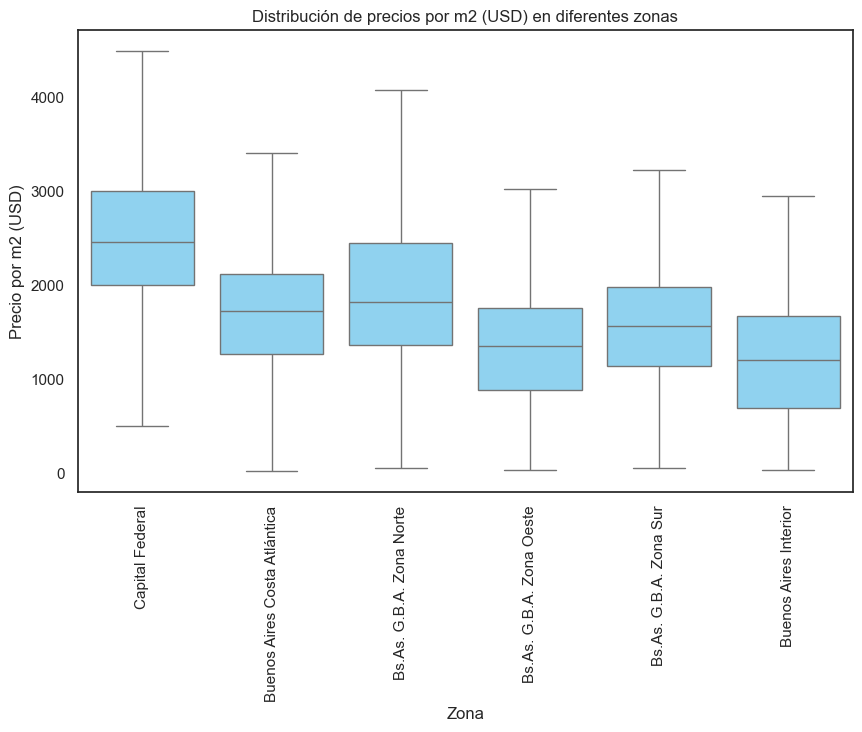

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='state_name', y='price_usd_per_m2_clean', data=muestra_trabajo, color="#80D8FF", showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Zona')
plt.ylabel('Precio por m2 (USD)')
plt.title('Distribución de precios por m2 (USD) en diferentes zonas')
plt.show()


Zona: Capital Federal - La muestra no parece provenir de una distribución normal.



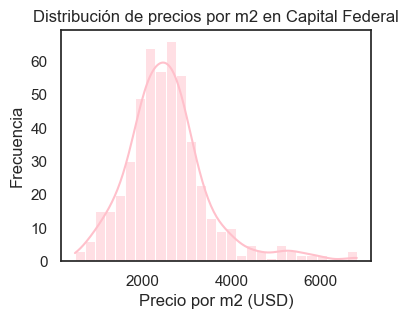

Zona: Bs.As. G.B.A. Zona Norte - La muestra no parece provenir de una distribución normal.



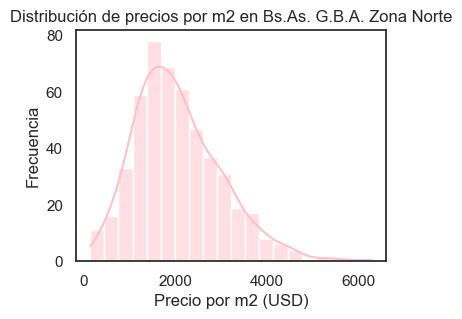

Zona: Bs.As. G.B.A. Zona Oeste - La muestra no parece provenir de una distribución normal.



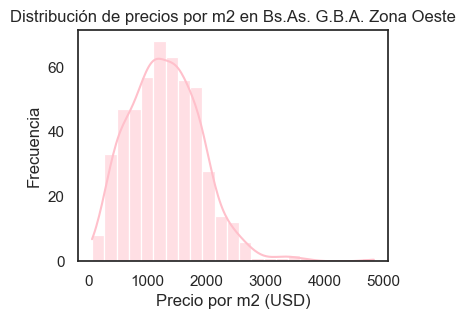

Zona: Bs.As. G.B.A. Zona Sur - La muestra no parece provenir de una distribución normal.



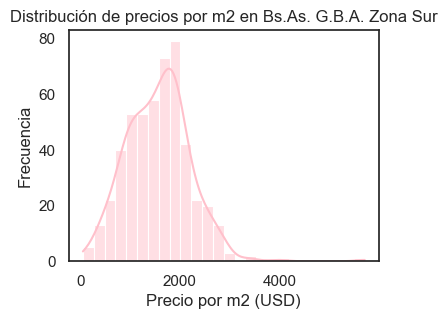

Zona: Buenos Aires Costa Atlántica - La muestra no parece provenir de una distribución normal.



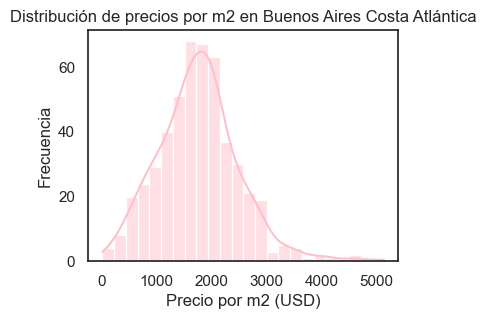

Zona: Buenos Aires Interior - La muestra no parece provenir de una distribución normal.



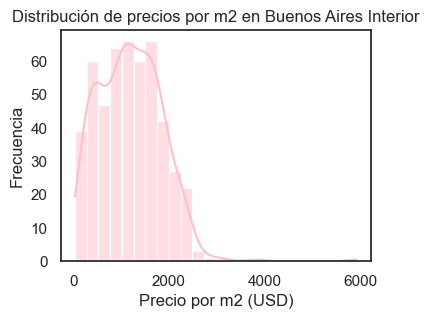


Prueba de Kruskal-Wallis:
Estadística de prueba: 817.0137
Valor p: 0.0000
Hay diferencias significativas entre las medianas de los grupos.



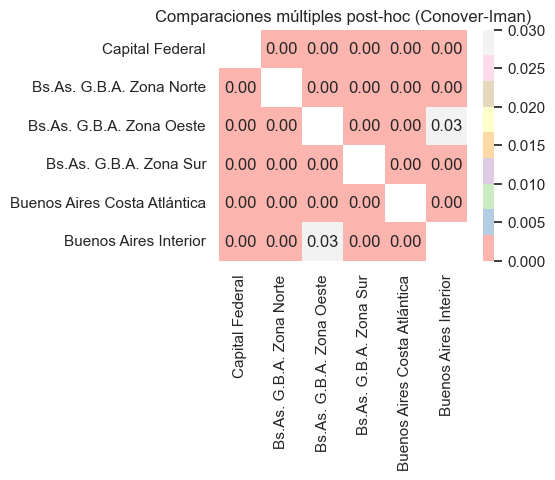

In [49]:
from scipy.stats import shapiro, kruskal
samples = []

# Prueba de Shapiro-Wilk y visualización de la distribución para cada zona
for zone in muestra_state:
    subset = muestra_trabajo[muestra_trabajo['state_name'] == zone].sample(n=500, random_state=1)
    
    # Realizar la prueba de Shapiro-Wilk
    stat, p_value = shapiro(subset['price_usd_per_m2_clean'])
    
    if p_value > 0.05:
        print(f'Zona: {zone} - La muestra parece provenir de una distribución normal.\n')
    else:
        print(f'Zona: {zone} - La muestra no parece provenir de una distribución normal.\n')
    
    # Visualizar la distribución de los precios por metro cuadrado por zona
    plt.figure(figsize=(4, 3))
    sns.histplot(subset['price_usd_per_m2_clean'], kde=True, color='pink')
    plt.title(f'Distribución de precios por m2 en {zone}')
    plt.xlabel('Precio por m2 (USD)')
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Agregar la muestra al conjunto de datos para la prueba de Kruskal-Wallis
    samples.append(subset['price_usd_per_m2_clean'])

# Prueba de Kruskal-Wallis
statistic, p_value_kruskal = kruskal(*samples)

print(f'\nPrueba de Kruskal-Wallis:')
print(f'Estadística de prueba: {statistic:.4f}')
print(f'Valor p: {p_value_kruskal:.4f}')

if p_value_kruskal > 0.05:
    print('No hay diferencias significativas entre las medianas de los grupos.\n')
else:
    print('Hay diferencias significativas entre las medianas de los grupos.\n')
    
result_posthoc = sp.posthoc_conover(samples)
result_posthoc_redondeo = np.round(result_posthoc, 2)
mask_significant = result_posthoc < 0.05

plt.figure(figsize=(4, 3))
sns.heatmap(result_posthoc_redondeo, annot=True, cmap='Pastel1', fmt=".2f", xticklabels=muestra_state, yticklabels=muestra_state, mask=~mask_significant)
plt.title('Comparaciones múltiples post-hoc (Conover-Iman)')
plt.show()


Conclusiones: Podemos observar que si bien existe dispersión en los promedios, por el diferente tamaño de cada sub-muestra los desvíos llegan a ser bastante significativos. La prueba de Kruskal-Wallis más su test post-hoc arroja como resultado que las medianas de cada grupo son significativamente diferentes (así como las distribuciones), pero al ser un test no paramétrico basado en rangos puede no ser enteramente sensible a la dispersión entre grupos que vemos gráficamente.

De cualquier manera, podemos anticipar que la ubicación geográfica (por lo menos a nivel "state_name" con los filtros aplicados) por sí sola no parece ser un factor que explique suficientemente la variabilidad de la variable target "price_usd_per_m2_clean", pero es posible que algunas de las categorías sean de principal importancia en un modelo de regresión lineal múltiple.

- <u> Pie chart + histograma de las propiedades por categoría en el total de zonas selecciondas y desglose en cada zona geográfica

En este gráfico observamos la representación de cada categoría de propiedad (a través de la variable ordinal "keyword_category") en cada zona geográfica.

Recordemos que estas categorías se construyeron a partir de las menciones en la columna no estructurada "description" del dataset original de las siguientes palabras clave asociadas a amenities o características deseables en las propiedades anunciadas: 'laundry', 'pileta'/ 'piscina', 'balcón', 'patio', 'terraza', 'cochera', 'a estrenar'/ 'nuevo', 'gimnasio', 'SUM', 'seguridad', 'baulera'.

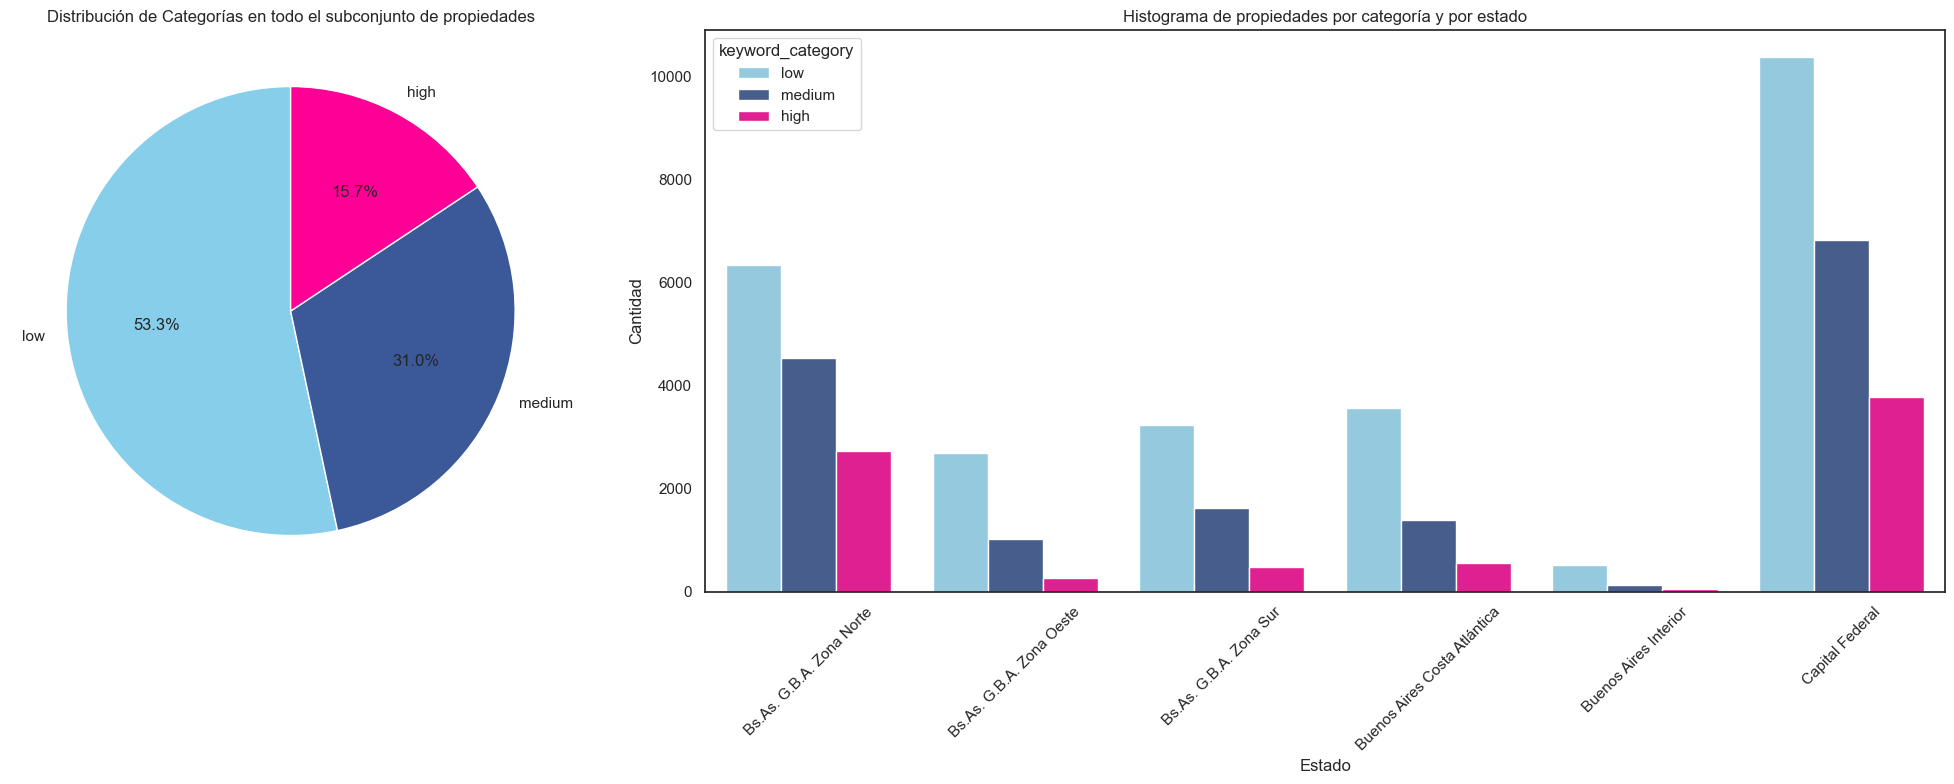

In [50]:
palette = sns.color_palette(['#87CEEB', '#3B5998', '#FF0097'])

keyword_category_order = ['low', 'medium', 'high']

# Grilla
fig, axs = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [2, 4]})

# Gráfico a (izquierda)
plt.subplot(1, 2, 1)
total_counts = muestra_trabajo['keyword_category'].value_counts()
plt.pie(total_counts, labels=total_counts.index, colors=palette, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Categorías en todo el subconjunto de propiedades')

# Gráfico b (derecha)
sns.barplot(x='state_name', y='count', hue='keyword_category', data=muestra_trabajo.groupby(['state_name', 'keyword_category']).size().reset_index(name='count'), palette=palette, hue_order=keyword_category_order, ax=axs[1])
axs[1].set_title('Histograma de propiedades por categoría y por estado')
axs[1].set_xlabel('Estado')
axs[1].set_ylabel('Cantidad')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Conclusión: Como podemos observar en los gráficos, la tendencia general y por zona es "low">"medium">"high", con una gran diferencia entre las tres categorías a excepción quizá de la Zona Norta de GBA y CABA, que según lo que analizamos en la etapa anterior, concentra muchas de las localidades más caras de nuestro país, por lo cual es de esperar que si el precio está influenciado por la cantidad de comodidades, exista una mayor representación de las categorías "medium" y "high" que en otras zonas (ej. propiedades "high" ascienden a más del 50% de "medium" y "medium" a aprox. un 75% de "low").

- <u> Gráfico de barras que muestra el precio por m2 (USD) promedio (+- ds) de las propiedades por categoría y en la zona geográfica definida

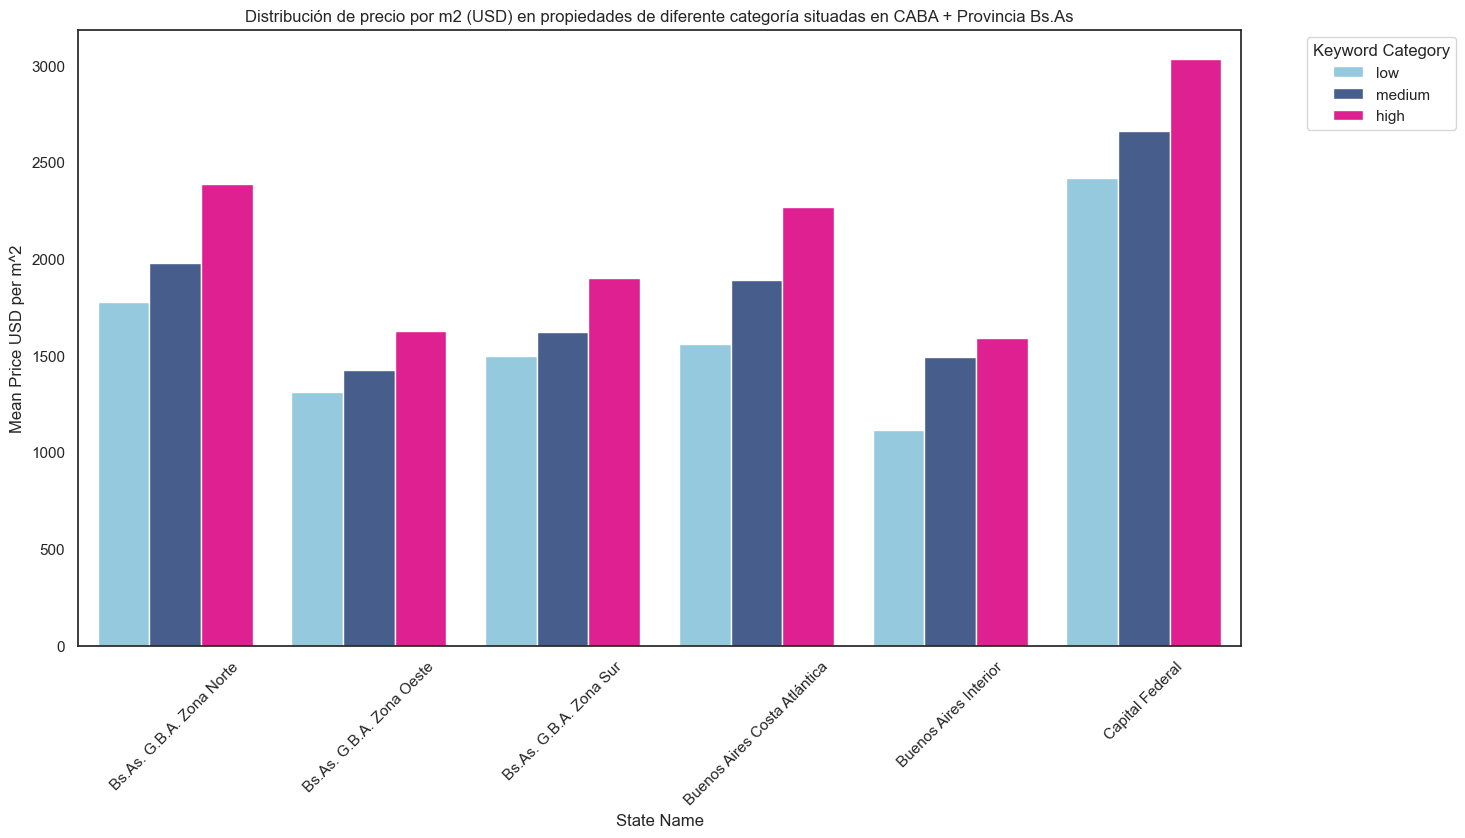

In [51]:
mean_price_data = muestra_trabajo.groupby(['state_name', 'keyword_category'])['price_usd_per_m2_clean'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(
    x='state_name',
    y='price_usd_per_m2_clean',
    hue='keyword_category',
    data=mean_price_data,
    palette=palette,
    hue_order=keyword_category_order
)
plt.title('Distribución de precio por m2 (USD) en propiedades de diferente categoría situadas en CABA + Provincia Bs.As')
plt.xlabel('State Name')
plt.ylabel('Mean Price USD per m^2')
plt.legend(title='Keyword Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.show()


Conclusión: salvo contadas excepciones, parecería que las propiedades de mayor categoría (definida como "keyword_category" y referenciada más arriba en este informe) tienen un costo/m2 superior a las de menor categoria. 

Los últimos dos gráficos nos señalan que la variable "keyword_category" podría ser interesante para incorporar al modelo, ya que se observan algunos patrones con relación al costo por m2.

- <U> Violinplots de precio por m2 (USD) por cantidad de habitaciones y por zona. Evaluación estadística de "rooms_clean" en relación al precio.

c:\Users\Tefi\anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


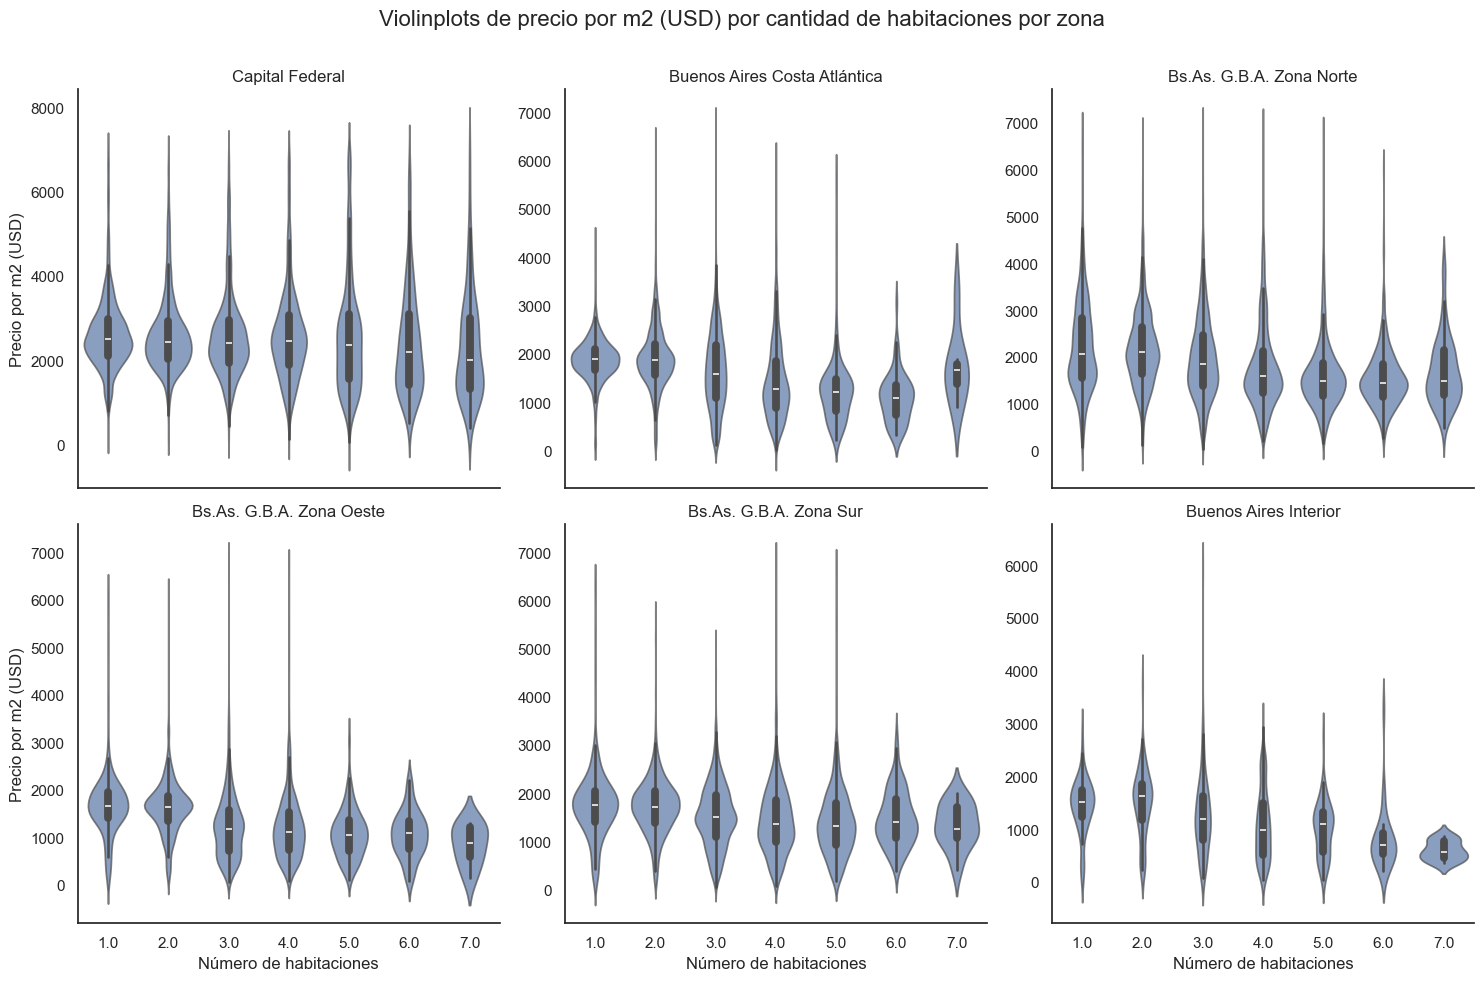

In [52]:
g = sns.FacetGrid(muestra_trabajo, col='state_name', col_wrap=3, height=5, sharey=False)
g.map(sns.violinplot, 'rooms_clean', 'price_usd_per_m2_clean', alpha=0.7)

g.set_axis_labels('Número de habitaciones', 'Precio por m2 (USD)')
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.figure.suptitle('Violinplots de precio por m2 (USD) por cantidad de habitaciones por zona', fontsize=16)

plt.show()

   Cantidad habitaciones  Estadístico  p-valor
0                 1.0000       0.8959   0.0000
0                 2.0000       0.9856   0.0196
0                 3.0000       0.9843   0.0119
0                 4.0000       0.9510   0.0000
0                 5.0000       0.8281   0.0000
0                 6.0000       0.8462   0.0000
0                 7.0000       0.8842   0.0000

Kruskal-Wallis Test:
Estadística de prueba: 98.3547
Valor p: 0.0000


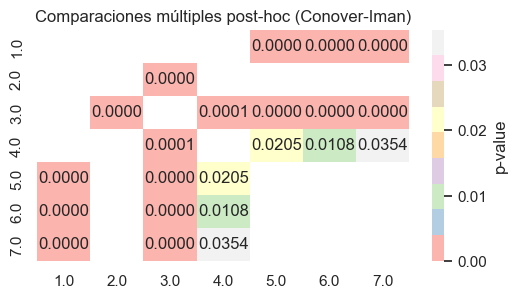

In [53]:
sns.set_theme(style="white")

def shapiro_wilk_test(sample):
    stat, p_value = stats.shapiro(sample)
    return stat, p_value

sample_size = 230
shapiro_results = pd.DataFrame(columns=['Cantidad habitaciones', 'Estadístico', 'p-valor'])

for room in muestra_trabajo['rooms_clean'].unique():
    subset = muestra_trabajo[muestra_trabajo['rooms_clean'] == room].sample(n=sample_size, random_state=42)
    stat, p_value = shapiro_wilk_test(subset['price_usd_per_m2_clean'])
    shapiro_results = pd.concat([shapiro_results, pd.DataFrame({'Cantidad habitaciones': [room], 'Estadístico': [stat], 'p-valor': [p_value]})], ignore_index=False)

shapiro_results['Cantidad habitaciones'] = pd.to_numeric(shapiro_results['Cantidad habitaciones'])
shapiro_results = shapiro_results.sort_values('Cantidad habitaciones')

pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print(shapiro_results)

pd.set_option('display.float_format', None)

# Kruskal-Wallis:
statistic, p_value_kruskal = stats.kruskal(*[subset['price_usd_per_m2_clean'].sample(n=sample_size, random_state=42) for _, subset in muestra_trabajo.groupby('rooms_clean')])
print(f'\nKruskal-Wallis Test:')
print(f'Estadística de prueba: {statistic:.4f}')
print(f'Valor p: {p_value_kruskal:.4f}')

# Prueba post-hoc: Conover-Iman test:
groups = muestra_trabajo['rooms_clean'].unique()
samples = [muestra_trabajo[muestra_trabajo['rooms_clean'] == group]['price_usd_per_m2_clean'].sample(n=sample_size, random_state=42) for group in groups]
result_posthoc = sp.posthoc_conover(samples, p_adjust='holm')

order = sorted(groups)

result_posthoc = result_posthoc.reindex(index=order, columns=order)

mask_significant = result_posthoc < 0.05

plt.figure(figsize=(6, 3))
sns.heatmap(result_posthoc, annot=True, cmap='Pastel1', fmt=".4f", xticklabels=order, yticklabels=order, mask=~mask_significant, cbar_kws={'label': 'p-value'})
plt.title('Comparaciones múltiples post-hoc (Conover-Iman)')
plt.show()


Conclusión: se pueden observar tendencias por zona, pero en general no se encuentra una gran amplitud en términos de la mediana y los valores máximos y mínimos, a excepción de Bs.As Interior donde también vemos que el n es menor.

Por otro lado al ser evaluada como única variable, existen diferencias significativas en los precios solo entre algunos de los grupos. Se recurrió a muestras pequeñas para que todos los grupos estuvieran balanceados (sample_size = 230 fue el valor más alto que funcionó para todos ellos).

Esta variable será incluida en el modelo, evaluando su performance como variable en la RLS y RLM. Sin embargo, los resultados podrían ser muy diferentes si tomamos otras variables en conjunto, como vemos en los violinplots donde además está cruzada con las zonas geográficas.

- <u> PairPlot de la variable target precio/m2 USD y una posible variable predictora/feature cuantitativa (superficie total en m2)

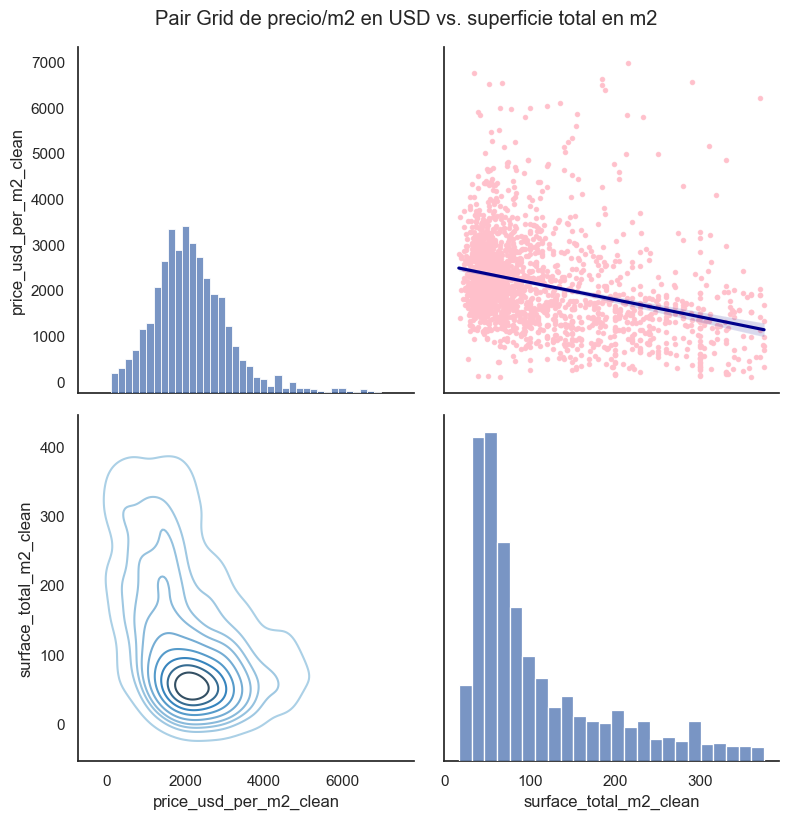

In [54]:
# Columnas continuas y muestra de datos
columnas_continuas = ['price_usd_per_m2_clean', 'surface_total_m2_clean']
sample_muestra = muestra_trabajo.sample(n=2000, random_state=42)

g = sns.PairGrid(sample_muestra[columnas_continuas], height=4)

g.map_upper(sns.scatterplot, color='pink', s=9)
g.map_upper(sns.regplot, scatter_kws={'color': 'pink', 's': 9}, line_kws={'color': 'darkblue'})
g.map_diag(sns.histplot)
g.map_lower(sns.kdeplot, cmap="Blues_d")

g.figure.suptitle('Pair Grid de precio/m2 en USD vs. superficie total en m2', y=1.02)

plt.show()


Interpretación de la serie de gráficos PairGrid:

Gráfico A (sup-izq): histograma de la variable 'price_usd_per_m2_clean'
Gráfico B (sup-der): gráfico de dispersión conjunta entre las dos variables y='price_usd_per_m2_clean' y x='surface_total_m2_clean'
Gráfico C (inf-izq): gráfico de densidad conjunta (KDE) entre las variables y='surface_total_m2_clean' y x='price_usd_per_m2_clean'
Gráfico D (inf-der): histograma de la variable 'surface_total_m2_clean'

Los gráficos B y C brindan información similar invirtiendo los ejes, el B nos permite ver puntos individuales y su dispersión (+ línea de regresión probable), mientras que C nos permite ver un patrón general.

Los resultados nos muestran que pareciera haber una relación directa (-) entre ambas variables, con una gran concentración de casos en los valores inferiores. Como vimos, en el dataset original, los departamentos representan la mayor proporción de las publicaciones y son principalmente de 1-2 ambientes, y la cantidad de habitaciones estaba fuerte y positivamente correlacionada con la superficie en m2 (coeficiente Spearman = 0.65). También habíamos encontrado una correlación negativa moderada entre superficie total y precio por m2 (USD). Una última razón podría tener que ver con la mayor cantidad de propiedades de menor categoría y su asociación aparente con un menor precio.

En la siguiente etapa de este informe, en la que exploraremos una posible regresión lineal con la superficie como feature, obtendremos información valiosa y objetiva sobre este análisis visual preliminar.

- Cargamos Scikit Learn y los modulos que vamos a usar posteriormente

In [55]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.compose import ColumnTransformer 
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
# Applies transformers to columns of an array or pandas DataFrame.

import statsmodels.api as sm

## a) <u> Construcción de modelos de regresión

### <u> 1) Selección hiperparámetros de Regresión Lineal

In [56]:
modelo = LinearRegression(fit_intercept= True)
modelo

LinearRegression()

### <u> 2) Preprocesamiento: preparación de matriz de features + vector target.

#### Clasificación de las features o posibles variables predictoras
- state_name: cualitativa categórica (6 categorías)
- keyword_category: categórica (3 categorías)
- rooms_clean: cuantitativa discreta
- surface_total_m2_clean: cuantitativa continua

#### Clasificación del target
- price_usd_per_m2_clean: cuantitativa continua

*Aclaración: "place_name_clean" (variable cualitativa categórica) se descarta del modelo por la gran cantidad de valores que toma y las complejidades asociadas a la creación de dummies/ one hot encoding)

- <u> Generamos dummies para las variables categóricas

In [57]:
features_categoricas = ['property_type', 'state_name', 'keyword_category']

df_RLM = muestra_trabajo.copy()

for cat in features_categoricas:
    # Obtener las variables dummy y agregar al DataFrame original
    dummies = pd.get_dummies(df_RLM[cat], drop_first=True, prefix=cat)
    df_RLM = pd.concat([df_RLM, dummies], axis=1)

df_RLM = df_RLM.drop(features_categoricas, axis=1)

df_RLM.head()

,place_name_clean,surface_total_m2_clean,price_usd_per_m2_clean,rooms_clean,property_type_apartment,property_type_house,state_name_Bs.As. G.B.A. Zona Oeste,state_name_Bs.As. G.B.A. Zona Sur,state_name_Buenos Aires Costa Atlántica,state_name_Buenos Aires Interior,state_name_Capital Federal,keyword_category_low,keyword_category_medium
0,Mataderos,55.0,1127.27,2.0,False,False,False,False,False,False,True,True,False
1,Mataderos,55.0,1309.09,2.0,True,False,False,False,False,False,True,True,False
2,Centro,35.0,1828.57,2.0,True,False,False,False,True,False,False,True,False
3,Munro,106.0,1226.42,3.0,False,False,False,False,False,False,False,True,False
4,Belgrano,45.0,3066.67,1.0,True,False,False,False,False,False,True,False,True


###### ** Nota: En esta etapa trabajamos con la generación de una escala ordinal para "keyword_category". En el modelo RLM trabjaremos con un total de 21 variables predictoras o features. De esta forma alternativa, se reduce a 15. Sin embargo, no se producían cambios en los resultados y la alteración del código nos trajo bastantes inconvenientes, por lo cual decidimos quedarnos con el enfoque original y ordenar las categorías cuando las vemos gráficamente.

In [58]:
df_RLM.shape

(50086, 13)

In [59]:
df_RLM.columns

Index(['place_name_clean', 'surface_total_m2_clean', 'price_usd_per_m2_clean',
       'rooms_clean', 'property_type_apartment', 'property_type_house',
       'state_name_Bs.As. G.B.A. Zona Oeste',
       'state_name_Bs.As. G.B.A. Zona Sur',
       'state_name_Buenos Aires Costa Atlántica',
       'state_name_Buenos Aires Interior', 'state_name_Capital Federal',
       'keyword_category_low', 'keyword_category_medium'],
      dtype='object')

Nota: la ausencia de las categorías 'state_name_Bs.As. G.B.A. Zona Norte', 'property_type_PH' y 'keyword_category_high' se debe a que las variables dummy se generaron para (n-1) categorías para evitar la colinealidad.

- <u> Generación de matriz Xy

In [60]:
feature_simple = ['surface_total_m2_clean']
features_completo = df_RLM.columns.drop(['price_usd_per_m2_clean', 'place_name_clean'])

X_simple = df_RLM.loc[:, feature_simple]
X_multi = df_RLM.loc[:, features_completo]

# Sumamos interacciones entre 'state_name' y 'keyword_category'
for state_col in ['state_name_Bs.As. G.B.A. Zona Oeste', 
                  'state_name_Bs.As. G.B.A. Zona Sur',
                  'state_name_Capital Federal',
                  'state_name_Buenos Aires Costa Atlántica',
                  'state_name_Buenos Aires Interior']:
    for keyword_col in ['keyword_category_low', 'keyword_category_medium']:
        interaction_col = f'{state_col}_x_{keyword_col}'
        X_multi.loc[:, interaction_col] = X_multi[state_col] * X_multi[keyword_col]

y = df_RLM['price_usd_per_m2_clean']


###### ** Nota: Probamos las siguientes interacciones entre features para evaluar si son significativas en nuestro modelo:

######      - X_multi['rooms_clean'] * X_multi['surface_total_m2_clean'] --> coeficiente interaction_term = coef -0.01, sin impacto significativo en la regresión ni en el R2.
######      -  X_multi['property_type'] * X_multi['keyword_category'] --> generó una mejora marginal en el modelo a expensas de un gran aumento en la cantidad de features.
######      - X_multi['state_name'] * X_multi['keyword_category'] --> genera 10 features nuevas pero reduce el error y aumenta levemente el R2 tanto de la RLM como de las variantes regularizadas.

- <u> Corroboro la longitud de cada uno para verificar que es la misma

In [61]:
X_simple.shape

(50086, 1)

In [62]:
X_multi.shape

(50086, 21)

In [63]:
y.shape

(50086,)

### 3) <u> Modelo de Regresión Lineal Simple 

Considerando las correlacion compartiadas en el primer analisis del dataset, exploramos la posibilidad de que alguno de los atributos nos permita predecir el valos de los inmuebles por m2. 

- <u> Análisis del modelo RLS de superficie total gráficamente y por Stats Models

In [64]:
X_simple = df_RLM[['surface_total_m2_clean']] 
y = df_RLM['price_usd_per_m2_clean'] 

# Replicar RLS para la variable X_simple
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(X_simple, y, test_size=0.35, random_state=1)
modelo_simple = LinearRegression()
modelo_simple.fit(X_simple_train, y_simple_train)


LinearRegression()

Métricas para datos de entrenamiento - MSE: 888010.99, R2: 0.105
Métricas para datos de prueba - MSE: 908678.945, R2: 0.099


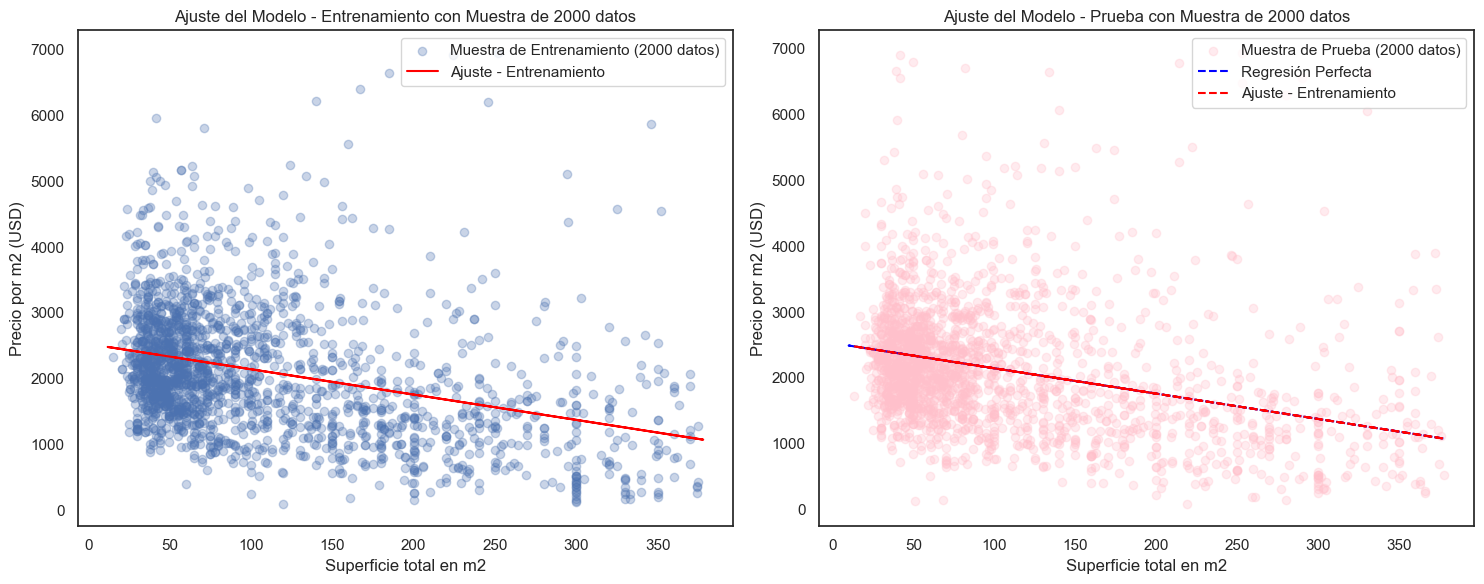

In [65]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_train = modelo_simple.predict(X_simple_train)
y_pred_test = modelo_simple.predict(X_simple_test)

# Métricas comparativas
mse_train = mean_squared_error(y_simple_train, y_pred_train).round(3)
r2_train = r2_score(y_simple_train, y_pred_train).round(3)

mse_test = mean_squared_error(y_simple_test, y_pred_test).round(3)
r2_test = r2_score(y_simple_test, y_pred_test).round(3)

print(f'Métricas para datos de entrenamiento - MSE: {mse_train}, R2: {r2_train}')
print(f'Métricas para datos de prueba - MSE: {mse_test}, R2: {r2_test}')

# Scatter plot con muestras de 2000 datos de entrenamiento y de prueba
random_indices_train = np.random.choice(len(X_simple_train), size=2000, replace=False)
X_simple_train_sample = X_simple_train.iloc[random_indices_train]
y_simple_train_sample = y_simple_train.iloc[random_indices_train]

random_indices_test = np.random.choice(len(X_simple_test), size=2000, replace=False)
X_simple_test_sample = X_simple_test.iloc[random_indices_test]
y_simple_test_sample = y_simple_test.iloc[random_indices_test]

# Calcular la pendiente y la intersección de la regresión perfecta en train
slope_perfect = np.cov(X_simple_train.values.flatten(), y_simple_train.values)[0, 1] / np.var(X_simple_train.values.flatten())
intercept_perfect = np.mean(y_simple_train.values) - slope_perfect * np.mean(X_simple_train.values)
y_perfect_test = slope_perfect * X_simple_test + intercept_perfect

# Calcular la pendiente y la intersección de la regresión en datos de entrenamiento
slope_train = modelo_simple.coef_[0]
intercept_train = modelo_simple.intercept_

# Crear la función de regresión ajustada a datos de entrenamiento
y_pred_train_line = slope_train * X_simple_train + intercept_train
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Ajuste a datos train (muestra de 2000 datos)
axes[0].scatter(X_simple_train_sample, y_simple_train_sample, alpha=0.3, label='Muestra de Entrenamiento (2000 datos)')
axes[0].plot(X_simple_train, y_pred_train, color='red', label='Ajuste - Entrenamiento')
axes[0].set_title('Ajuste del Modelo - Entrenamiento con Muestra de 2000 datos')
axes[0].set_xlabel('Superficie total en m2')
axes[0].set_ylabel('Precio por m2 (USD)')
axes[0].legend(loc='upper right')

# Ajuste a datos test (muestra de 2000 datos)
axes[1].scatter(X_simple_test_sample, y_simple_test_sample, alpha=0.3, label='Muestra de Prueba (2000 datos)', color='pink')
axes[1].plot(X_simple_test, y_perfect_test, linestyle='--', color='blue', label='Regresión Perfecta')
y_pred_train_line_sample = slope_train * X_simple_test_sample + intercept_train

axes[1].plot(X_simple_test_sample, y_pred_train_line_sample, linestyle='--', color='red', label='Ajuste - Entrenamiento')
axes[1].set_title('Ajuste del Modelo - Prueba con Muestra de 2000 datos')
axes[1].set_xlabel('Superficie total en m2')
axes[1].set_ylabel('Precio por m2 (USD)')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [66]:
# Agregar constante
X_simple_train_with_const = sm.add_constant(X_simple_train)

# Fit con el modelo OLS
model_stats = sm.OLS(y_simple_train, X_simple_train_with_const).fit()

print(model_stats.summary())

                              OLS Regression Results                              
Dep. Variable:     price_usd_per_m2_clean   R-squared:                       0.105
Model:                                OLS   Adj. R-squared:                  0.105
Method:                     Least Squares   F-statistic:                     3819.
Date:                    Wed, 14 Feb 2024   Prob (F-statistic):               0.00
Time:                            22:35:40   Log-Likelihood:            -2.6914e+05
No. Observations:                   32555   AIC:                         5.383e+05
Df Residuals:                       32553   BIC:                         5.383e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

Conclusiones:

- El valor p asociado con el estadístico F (Prob F-statistic) es cero (< 0.05), lo que sugiere que el modelo en su conjunto es significativo. Además vemos la significancia de los componentes del modelo por separado B1 y B2 (const y surface_total_m2_clean) con un error estándar bajo para la variable independiente.

- El coeficiente negativo para surface_total_m2_clean (-3.8439) indica que, en promedio, hay una caída de USD 3.8439 en el precio por metro cuadrado por cada m2 adicional de superficie total sin tomar en cuenta otras variables (como zona, tipo de propiedad y categoría). Esto sugiere una relación negativa entre la superficie total y el precio por metro cuadrado: a medida que la superficie total aumenta, el precio por metro cuadrado tiende a disminuir. Esto es coincidente con la relación negativa que observamos en el heatmap de correlación de la primera parte, y los gráficos preliminares (pairgrid) de la introducción.

- A través de la salida de Stats Model, el modelo simple con surface_total_m2_clean proporciona una explicación significativa pero limitada de la variabilidad en el precio por metro cuadrado, y es posible que se necesiten más variables para mejorar la capacidad predictiva del modelo.

- En el gráfico vemos la adecuación del modelo a los datos de entrenamiento vs. los de prueba, teniendo en cuenta los R2 similares en ambos podemos corroborar visualmente que el modelo de RLS performa bien en el subconjunto predicho Test.

In [67]:
features_lin = df_RLM.columns
features_lin = features_lin.drop('price_usd_per_m2_clean')
modelo_simple = modelo

for features in features_lin:
    if df_RLM[features].dtype == 'object':
        X = pd.get_dummies(df_RLM[features])
    else:
        X = df_RLM[features].values.reshape(-1,1)
    y = df_RLM['price_usd_per_m2_clean']
    X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(X, y, test_size=0.35, random_state=1)
    modelo_simple.fit(X_simple_train, y_simple_train)
    y_simple_pred = modelo_simple.predict(X_simple_test)
    mse = mean_squared_error(y_simple_test, y_simple_pred)
    r2 = r2_score(y_simple_test, y_simple_pred)
    print(f'{features}--> MSE = {mse}  R2 = {r2}')

place_name_clean--> MSE = 9.81834185457167e+28  R2 = -9.73385450646231e+22
surface_total_m2_clean--> MSE = 908678.9450307484  R2 = 0.09914028508830808
rooms_clean--> MSE = 982799.8729747408  R2 = 0.025657171628079678
property_type_apartment--> MSE = 758461.3752584574  R2 = 0.24806522477117277
property_type_house--> MSE = 815416.876945516  R2 = 0.19159982817202537
state_name_Bs.As. G.B.A. Zona Oeste--> MSE = 957454.9551944367  R2 = 0.05078399505772613
state_name_Bs.As. G.B.A. Zona Sur--> MSE = 974920.7264838592  R2 = 0.033468517648959306
state_name_Buenos Aires Costa Atlántica--> MSE = 989114.9397432205  R2 = 0.019396446341319207
state_name_Buenos Aires Interior--> MSE = 998802.7930658091  R2 = 0.009791957506158466
state_name_Capital Federal--> MSE = 827449.4147857251  R2 = 0.1796708309528502
keyword_category_low--> MSE = 955942.1347027108  R2 = 0.052283797649545494
keyword_category_medium--> MSE = 1004984.6599331249  R2 = 0.003663285928405813


Conclusión: El análisis preliminar, que nos permite examinar las métricas de rendimiento para cada feature como única variable predictora del target, nos permite observar la variable "surface_total_m2_clean" tiene un MSE relativamente bajo y un R2 cercano al 10%. Estos resultados sugieren que esta variable puede ser una buena elección como feature para un modelo de regresión lineal simple. Además, en el contexto del análisis desarrollado en el primer informe y el pair grid presentado en la parte introductoria. Luego de este analisis explorativo sobre el rendimiento de las otras features, nos damos cuenta que otra elección posible hubiera sido el tipo de propiedad pero preferimos inclinarnos en esta instancia por una variable cuantitativa.

### 4) <u> Modelos de Regresión Lineal Múltiple usando todas las features preseleccionadas

- <u> Separación en sets de entramiento y prueba

In [68]:
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_multi, y, test_size=0.35, random_state=1)

In [69]:
X_multi_train.shape

(32555, 21)

In [70]:
X_multi_train.columns

Index(['surface_total_m2_clean', 'rooms_clean', 'property_type_apartment',
       'property_type_house', 'state_name_Bs.As. G.B.A. Zona Oeste',
       'state_name_Bs.As. G.B.A. Zona Sur',
       'state_name_Buenos Aires Costa Atlántica',
       'state_name_Buenos Aires Interior', 'state_name_Capital Federal',
       'keyword_category_low', 'keyword_category_medium',
       'state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_low',
       'state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_medium',
       'state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_low',
       'state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_medium',
       'state_name_Capital Federal_x_keyword_category_low',
       'state_name_Capital Federal_x_keyword_category_medium',
       'state_name_Buenos Aires Costa Atlántica_x_keyword_category_low',
       'state_name_Buenos Aires Costa Atlántica_x_keyword_category_medium',
       'state_name_Buenos Aires Interior_x_keyword_category_low',
       'state_n

In [71]:
y_multi_train.shape

(32555,)

- <u> Reescalado features cuantitativas utilizando Standard Scaler y reemplazo en el conjunto de entrenamiento

In [72]:
features_cuantitativas = ['surface_total_m2_clean', 'rooms_clean']

scaler = StandardScaler()

#Features - entrenamiento/train
features_train_escaladas = scaler.fit_transform(X_multi_train[features_cuantitativas])
X_multi_train[features_cuantitativas] = features_train_escaladas

#Features - prueba/test
features_test_escaladas = scaler.transform(X_multi_test[features_cuantitativas])
X_multi_test[features_cuantitativas] = features_test_escaladas


- <u> Ajuste al modelo de RLM

In [73]:
modelo.fit(X_multi_train, y_multi_train)

LinearRegression()

- <u> Definición de coeficientes para cada feature

In [74]:
coeficientes = modelo.coef_

for feature, coeficiente in zip(X_multi.columns, coeficientes):
    redondeo_coeficiente = round(coeficiente, 2)
    print(f'{feature}: {redondeo_coeficiente}')


surface_total_m2_clean: -78.68
rooms_clean: 29.69
property_type_apartment: 825.36
property_type_house: 120.55
state_name_Bs.As. G.B.A. Zona Oeste: -759.74
state_name_Bs.As. G.B.A. Zona Sur: -443.17
state_name_Buenos Aires Costa Atlántica: -220.98
state_name_Buenos Aires Interior: -824.38
state_name_Capital Federal: 536.65
keyword_category_low: -281.28
keyword_category_medium: -167.01
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_low: 323.5
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_medium: 219.1
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_low: 72.57
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_medium: 55.03
state_name_Capital Federal_x_keyword_category_low: -285.25
state_name_Capital Federal_x_keyword_category_medium: -156.63
state_name_Buenos Aires Costa Atlántica_x_keyword_category_low: -236.7
state_name_Buenos Aires Costa Atlántica_x_keyword_category_medium: -97.42
state_name_Buenos Aires Interior_x_keyword_category_low: 192.03
state_name_Buenos

- <u> Intercepto / ordenada al origen

In [75]:
modelo.intercept_

1688.1506078071861

- <u> Predicción de target para datos nuevos (datos "test")

In [76]:
y_multi_pred = modelo.predict(X_multi_test)
y_multi_pred

array([1022.0041787 , 2218.82390699, 2512.38576448, ..., 2276.87534335,
       1709.95752358, 2538.60042691])

- <u> Evaluación de la performance del modelo

In [77]:
# Cálculo de R2 ajustado
n = len(y_multi_test)
k = X_multi_test.shape[1]
r2 = r2_score(y_multi_test, y_multi_pred)
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Cálculo de errores y R2 para evaluar la performance del modelo
print ("y_test sample: ",y_multi_test.values[0:10].astype(int))
print ("y_pred sample: ",y_multi_pred[0:10].astype(int))
print ('Mean Absolute Error:', mean_absolute_error(y_multi_test, y_multi_pred).round(3))
print ('Mean Squared Error:', mean_squared_error(y_multi_test, y_multi_pred).round(3))
print ('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_multi_test, y_multi_pred)).round(3))
print ('R2:', r2.round(4))
print ('Cantidad de features:', k)
print ('R2 Ajustado:', adjusted_r2.round(4))


y_test sample:  [ 500 2600 2706 2416 3266 2784 1665  526 1313 2222]
y_pred sample:  [1022 2218 2512 2228 3111 3076 2739 1838 1452 1830]
Mean Absolute Error: 562.295
Mean Squared Error: 627986.967
Root Mean Squared Error: 792.456
R2: 0.3774
Cantidad de features: 21
R2 Ajustado: 0.3767


In [78]:
mae_rlm=mean_absolute_error(y_multi_test, y_multi_pred).round(3)
mse_rlm=mean_squared_error(y_multi_test, y_multi_pred).round(3)
rmse_rlm=np.sqrt(mean_squared_error(y_multi_test, y_multi_pred)).round(3)
sse_rlm = np.sum(np.square(y_multi_test - y_multi_pred)).round(3)

print ('Mean Absolute Error:',mae_rlm )
print ('Mean Squared Error:', mse_rlm)
print ('Root Mean Squared Error:',rmse_rlm )
print('Suma de los errores cuadráticos:', sse_rlm)

Mean Absolute Error: 562.295
Mean Squared Error: 627986.967
Root Mean Squared Error: 792.456
Suma de los errores cuadráticos: 11009239518.971


- <u> Gráficos

Generaremos líneas de código a reutilizar, dado que repetiremos este tipo de gráfico para las regularizaciones.

In [79]:
feature_names = X_multi.columns

# Separar interacciones de Features sin interacción
interaction_features = [feature for feature in feature_names if 'x' in feature]
non_interaction_features = [feature for feature in feature_names if 'x' not in feature]

# Indices para features
interaction_indices = [feature_names.get_loc(feature) for feature in interaction_features]
non_interaction_indices = [feature_names.get_loc(feature) for feature in non_interaction_features]

Generamos un gráfico de barras horizontales para observar la magnitud y signo de los coeficientes de los features en el modelo de RLM sin regularización (a mayor magnitud en módulo mayor "importanca" en el modelo de regresión o influencia en los movimientos del target, y el signo determina si es una relación positiva donde ambos crecen o negativa, donde la feature crece y el target decrece o vice versa).

Ordenamos las variables feature de tal forma que en azul claro en la parte superior observamos las que no inclyen interacción, y en celeste en la parte inferior observamos las interacciones.

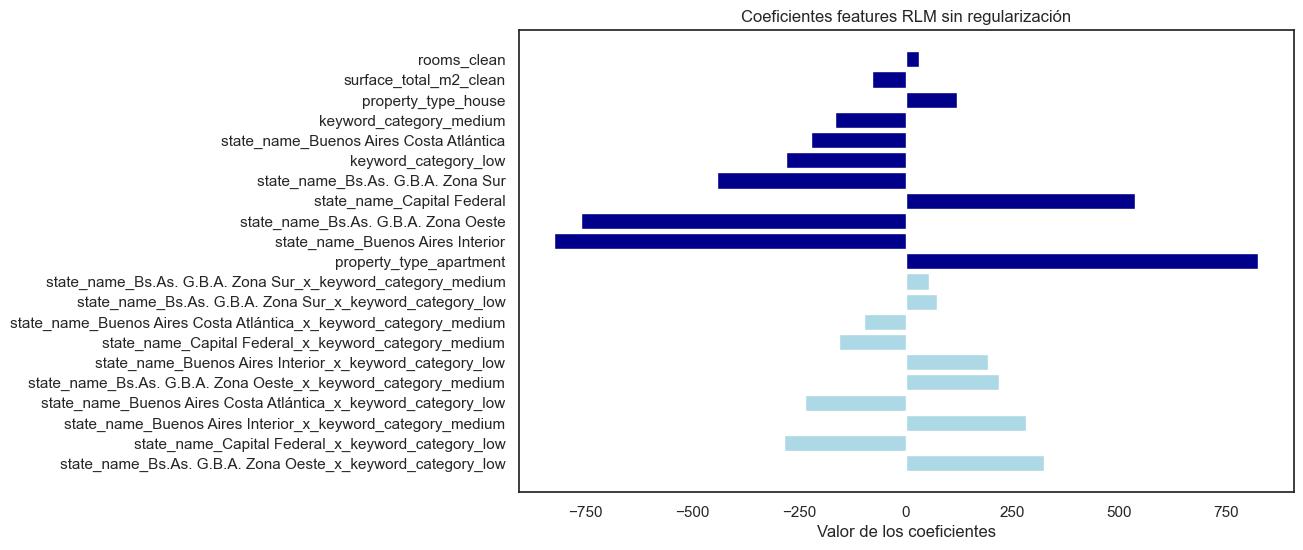

In [80]:
# Llamamos a los coeficientes de acuerdo al modelo
coeficientes = coeficientes

# Ordenar en el gráfico las features de interacción y las de no-interacción
sorted_interaction_indices = (-abs(coeficientes[interaction_indices])).argsort()
sorted_interaction_feature_names = [interaction_features[i] for i in sorted_interaction_indices]
sorted_non_interaction_indices = (-abs(coeficientes[non_interaction_indices])).argsort()
sorted_non_interaction_feature_names = [non_interaction_features[i] for i in sorted_non_interaction_indices]
sorted_feature_names = sorted_interaction_feature_names + sorted_non_interaction_feature_names
sorted_coefficients = coeficientes[feature_names.get_indexer(sorted_feature_names)]

# Colores de acuerdo a si se trata de una feature de interacción o no-interacción
colors = ['lightblue' if 'x' in feature else 'darkblue' for feature in sorted_feature_names]

# Graficar
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_feature_names, sorted_coefficients, color=colors)
plt.xlabel('Valor de los coeficientes')
plt.title('Coeficientes features RLM sin regularización')

plt.show()

C:\Users\Tefi\AppData\Local\Temp\ipykernel_1472\2771225070.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(coeficientes), y=X_multi.columns, palette=colors)


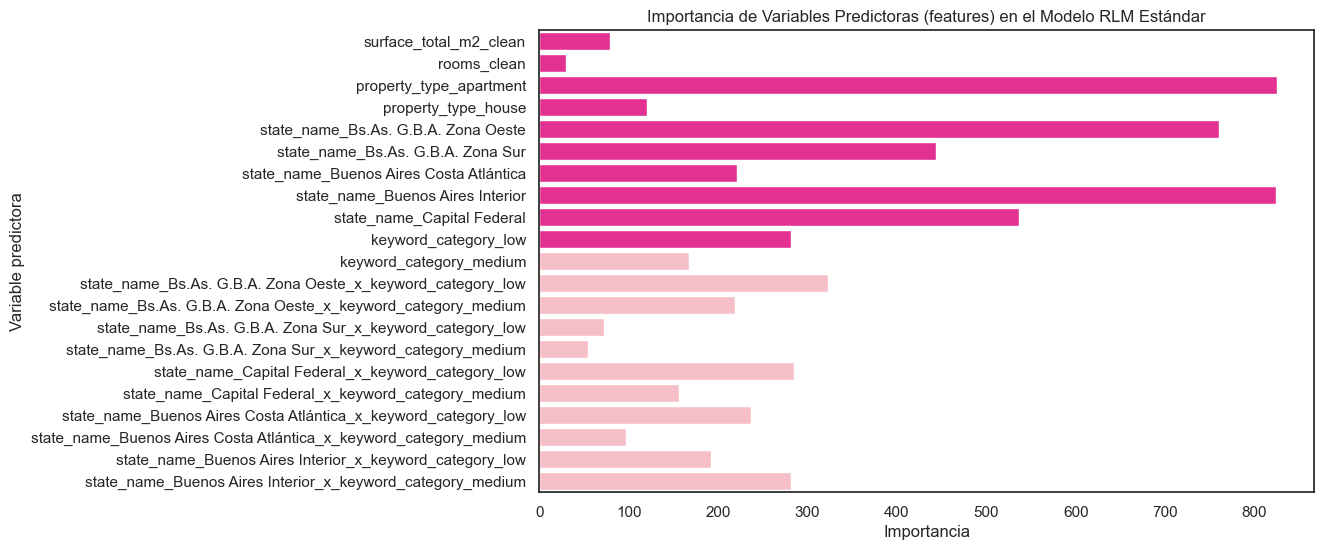

In [81]:
# Colores de acuerdo a si se trata de una feature de interacción o no-interacción
colors = ['deeppink' if 'x' in feature else 'lightpink' for feature in sorted_feature_names]

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=np.abs(coeficientes), y=X_multi.columns, palette=colors)
plt.title('Importancia de Variables Predictoras (features) en el Modelo RLM Estándar')
plt.xlabel('Importancia')
plt.ylabel('Variable predictora')

plt.show()

Conclusiones (aplicable también para este mismo modelo con regularizaciones): 

- Es notable que las zonas asociadas a un menor precio por m2 (USD) son aquellas que ejercen una presión más fuerte y negativa sobre la variable, corroborándose esta relación. 

- Asimismo, las features cuantitativas no fueron tan influyentes en el modelo. 

- Finalmente, los coeficientes de las interacciones son comparables a los de las features sin interacción. Si bien quizá los casos de cada cruce son menos entonces la influencia sobre el modelo general es menor, es interesante ver que al sacar este factor son features a tener en cuenta.

- <u> Evaluación del modelo con Stats Models

In [82]:
X_multi_train_const = sm.add_constant(X_multi_train)

model_multi = sm.OLS(y_multi_train, X_multi_train_const).fit()

model_multi.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const                                                                float64
surface_total_m2_clean                                               float64
rooms_clean                                                          float64
property_type_apartment                                                 bool
property_type_house                                                     bool
state_name_Bs.As. G.B.A. Zona Oeste                                     bool
state_name_Bs.As. G.B.A. Zona Sur                                       bool
state_name_Buenos Aires Costa Atlántica                                 bool
state_name_Buenos Aires Interior                                        bool
state_name_Capital Federal                                              bool
keyword_category_low                                                    bool
keyword_category_medium                                                 bool
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_low              bool
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_medium           bool
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_low                bool
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_medium             bool
state_name_Capital Federal_x_keyword_category_low                       bool
state_name_Capital Federal_x_keyword_category_medium                    bool
state_name_Buenos Aires Costa Atlántica_x_keyword_category_low          bool
state_name_Buenos Aires Costa Atlántica_x_keyword_category_medium       bool
state_name_Buenos Aires Interior_x_keyword_category_low                 bool
state_name_Buenos Aires Interior_x_keyword_category_medium              bool
dtype: object. The data was
45923    2547.17
25902     797.87
59106    2720.33
57612    1830.77
19028    1083.33
          ...   
59930    2595.24
37181    4206.13
5897     1000.00
13831    2142.86
37727    5000.00
Name: price_usd_per_m2_clean, Length: 32555, dtype: float64
and
        const  surface_total_m2_clean  rooms_clean  property_type_apartment  \
45923    1.0               -0.680442    -0.614562                     True   
25902    1.0                0.927204     0.961915                    False   
59106    1.0               -0.870978    -1.402800                     True   
57612    1.0               -0.537540    -0.614562                     True   
19028    1.0               -0.597083    -0.614562                     True   
...      ...                     ...          ...                      ...   
59930    1.0               -0.311279     0.961915                     True   
37181    1.0               -0.763802    -0.614562                     True   
5897     1.0                0.712851     1.750153                    False   
13831    1.0               -0.894795    -0.614562                     True   
37727    1.0               -0.787619    -0.614562                     True   

       property_type_house  state_name_Bs.As. G.B.A. Zona Oeste  \
45923                False                                False   
25902                 True                                False   
59106                False                                False   
57612                False                                False   
19028                False                                False   
...                    ...                                  ...   
59930                False                                False   
37181                False                                False   
5897                  True                                False   
13831                False                                False   
37727                False                                False   

       state_name_Bs.As. G.B.A. Zona Sur  \
45923                              False   
25902                              False   
59106                              False   
57612                              False   
19028                              False   
...                                  ...   
59930                              False   
37181                              False   
5897                               False   
13831                              False   
37727                              False   

       state_name_Buenos Aires Costa Atlántica  \
45923                                    False   
25902                                     True   
59106                                    False   
57612                                     True   
19028                                     True   
...                                        ...   
59930                                    False   
37181                                    False   
5897                                      True   
13831                                    False   
37727                                    False   

       state_name_Buenos Aires Interior  state_name_Capital Federal  ...  \
45923                             False                        True  ...   
25902                             False                       False  ...   
59106                             False                        True  ...   
57612                             False                       False  ...   
19028                             False                       False  ...   
...                                 ...                         ...  ...   
59930                             False                        True  ...   
37181                             False                        True  ...   
5897                              False                       False  ...   
13831                             False                        True  ...   
37727                             False                        True  ...   

       state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_low  \
45923                                              False            
25902                                              False            
59106                                              False            
57612                                              False            
19028                                              False            
...                                                  ...            
59930                                              False            
37181                                              False            
5897                                               False            
13831                                              False            
37727                                              False            

       state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_medium  \
45923                                              False               
25902                                              False               
59106                                              False               
57612                                              False               
19028                                              False               
...                                                  ...               
59930                                              False               
37181                                              False               
5897                                               False               
13831                                              False               
37727                                              False               

       state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_low  \
45923                                              False          
25902                                              False          
59106                                              False          
57612                                              False          
19028                                              False          
...                                                  ...          
59930                                              False          
37181                                              False          
5897                                               False          
13831                                              False          
37727                                              False          

       state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_medium  \
45923                                              False             
25902                                              False             
59106                                              False             
57612                                              False             
19028                                              False             
...                                                  ...             
59930                                              False             
37181                                              False             
5897                                               False             
13831                                              False             
37727                                              False             

       state_name_Capital Federal_x_keyword_category_low  \
45923                                              False   
25902                                              False   
59106                                               True   
57612                                              False   
19028                                              False   
...                                                  ...   
59930                                              False   
37181                                               True   
5897                                               False   
13831                                               True   
37727                                              False   

       state_name_Capital Federal_x_keyword_category_medium  \
45923                                               True      
25902                                              False      
59106                                              False      
57612                                              False      
19028                                              False      
...                                                  ...      
59930                                               True      
37181                                              False      
5897                                               False      
13831                                              False      
37727                                               True      

       state_name_Buenos Aires Costa Atlántica_x_keyword_category_low  \
45923                                              False                
25902                                               True                
59106                                              False                
57612                                               True                
19028                                               True                
...                                                  ...                
59930                                              False                
37181                                              False                
5897                                               False                
13831                                              False                
37727                                              False                

       state_name_Buenos Aires Costa Atlántica_x_keyword_category_medium  \
45923                                              False                   
25902                                              False                   
59106                                              False                   
57612                                              False                   
19028                                              False                   
...                                                  ...                   
59930                                              False                   
37181                                              False                   
5897                                                True                   
13831                                              False                   
37727                                              False                   

       state_name_Buenos Aires Interior_x_keyword_category_low  \
45923                                              False         
25902                                              False         
59106                                              False         
57612                                              False         
19028                                              False         
...                                                  ...         
59930                                              False         
37181                                              False         
5897                                               False         
13831                                              False         
37727                                              False         

       state_name_Buenos Aires Interior_x_keyword_category_medium  
45923                                              False           
25902                                              False           
59106                                              False           
57612                                              False           
19028                                              False           
...                                                  ...           
59930                                              False           
37181                                              False           
5897                                               False           
13831                                              False           
37727                                              False           

[32555 rows x 22 columns]
before. After,
[2547.17  797.87 2720.33 ... 1000.   2142.86 5000.  ]
[[1.0 -0.6804421678686987 -0.614561984332962 ... False False False]
 [1.0 0.9272041816117466 0.9619146841690932 ... False False False]
 [1.0 -0.8709780315108255 -1.4028003185839897 ... False False False]
 ...
 [1.0 0.7128513350143538 1.7501530184201208 ... True False False]
 [1.0 -0.8947950144660914 -0.614561984332962 ... False False False]
 [1.0 -0.7876185911673951 -0.614561984332962 ... False False False]].

Conclusión: podemos ver que el modelo resulta significativo, con la mayoría de las variables predictoras o features con p valores < 0,05. Es notable que algunas interacciones no resulten significativas, particularmente en zonas con menor cantidad de registros y alto desvío estándar ("state_name_Bs.As. G.B.A Zona Sur x keyword_category_low", "state_name_Bs.As. G.B.A Zona Sur x keyword_category_medium", "state_name_Bs.As. Costa Atlántica x keyword_category_medium", "state_name_Bs.As. Interior x keyword_category_low" y "state_name_Bs.As. Interior x keyword_category_medium"). Al repetir este análisis anulando estas features, sin embargo, no se verificaron mejoras en los parámetros de análisis del modelo.

Generamos una muestra de 2000 predicciones para los gráficos

In [107]:
sample_size = 2000
y_multi_pred_sample = y_multi_pred[:sample_size]
y_multi_test_sample = y_multi_test[:sample_size]

- <u> Valores predichos vs. residuos (diferencias entre los valores reales y las predicciones del modelo)

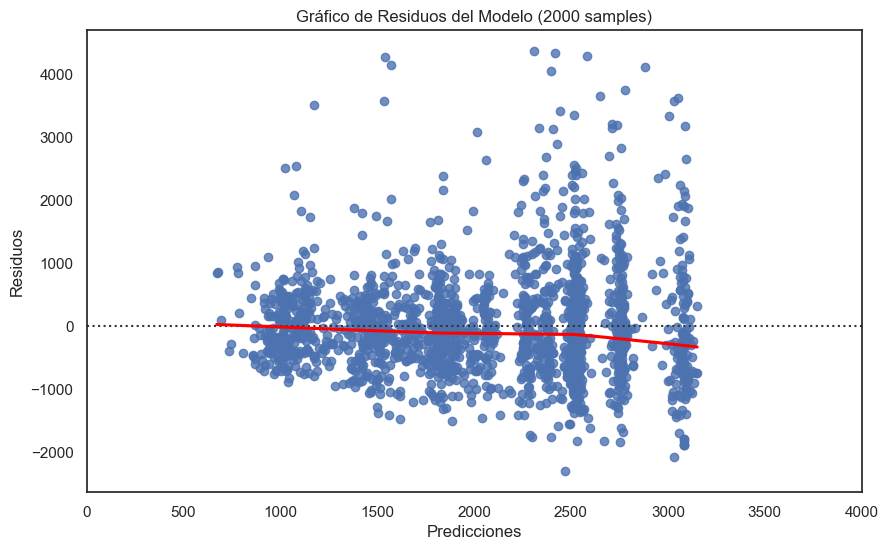

In [108]:
plt.figure(figsize=(10, 6))
sns.residplot(x=y_multi_pred_sample, y=y_multi_test_sample, lowess=True, line_kws={'color': 'red'})

plt.title('Gráfico de Residuos del Modelo (2000 samples)')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.xlim(0, 4000)

plt.show()

Conclusión: El modelo muestra una leve tendencia hacia la negatividad en la dispersión de los residuos. En términos gráficos, los puntos no se ubican de forma perfectamente aleatoriamente alrededor e la línea punteada en "0", sino que como se ve a través de la línea roja el promedio de los residuos cae levemente a medida que aumentan las predicciones. Esto equivale a decir que el modelo tiene una tendencia leve a subestimar los valores reales a medida que aumentan las predicciones. Vale resaltar que esto no se da de forma constante a lo largo de las predicciones, por lo tanto no parecería constituir un sesgo. A partir de la información gráfica podría deberse a la heterocedasticidad de los datos (dispersión que aumenta a medida que aumentan las predicciones) o una relación entre ambas variables en estudio que no logramos explicar a partir de este modelo lineal.

- <u> Gráfico de valores predichos vs. reales para la variable target

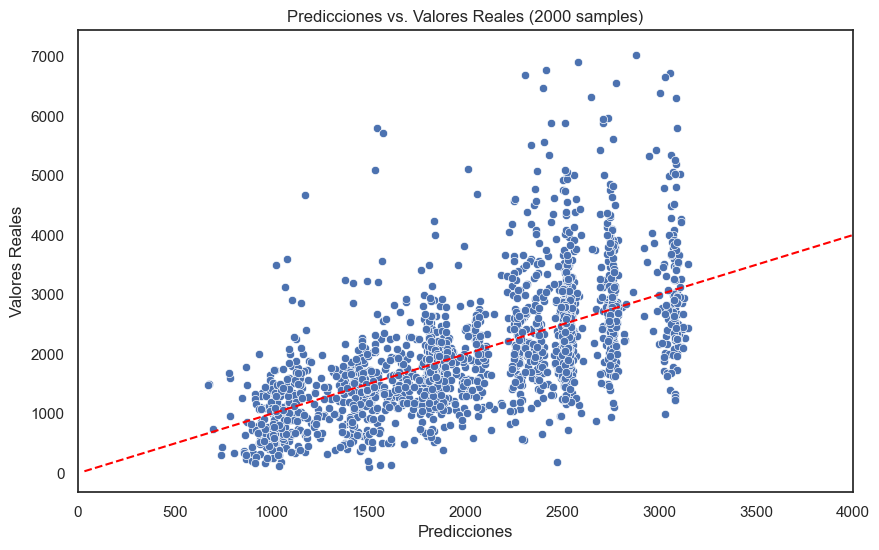

In [109]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_multi_pred_sample, y=y_multi_test_sample)
plt.plot([min(y_multi_test), max(y_multi_test)], [min(y_multi_test), max(y_multi_test)], linestyle='--', color='red')
plt.xlim(0, 4000)
plt.title('Predicciones vs. Valores Reales (2000 samples)')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Conclusión: Al examinar la dispersión de los puntos en el gráfico de valores reales versus predicciones, se evidencia una significativa variabilidad en las predicciones del modelo en comparación con la relación ideal representada por la línea roja ("equivalencia perfecta"). Esta dispersión sugiere que el modelo tiene áreas de mejora sustanciales en términos de precisión de predicciones, en especial en aquellos casos donde las predicciones divergen más significativamente de los valores reales. Estas observaciones resaltan la necesidad de realizar ajustes en el modelo para mejorar la precisión y el R2, para fortalecer la confiabilidad del modelo y su utilidad en aplicaciones prácticas.

- <u>Definición de hiperparámetros para RLM con regularizaciones de Lasso y Ridge

In [86]:
alphas = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
folds_range = range(2,11)

### 5) <u> Regresión Lineal Múltiple con Regularizacion LASSO -Cross Validation

In [87]:
best_score_lasso = -np.inf
best_fold_lasso = None

for folds in folds_range:
    lasso_cv_model = LassoCV(alphas=alphas, cv=folds)
    scores_lasso = cross_val_score(lasso_cv_model, X_multi_train, y_multi_train, cv=folds)
    mean_score_lasso = scores_lasso.mean()
    if mean_score_lasso > best_score_lasso:
        best_score_lasso = mean_score_lasso
        best_fold_lasso = folds
    
print('Mejor número de folds para Lasso:', best_fold_lasso)
print('Mejor score promedio para Lasso:', best_score_lasso)

Mejor número de folds para Lasso: 4
Mejor score promedio para Lasso: 0.36821507980845336


In [88]:
lasso_cv_model = LassoCV(alphas=alphas, cv=best_fold_lasso)
modelo_lasso_cv = lasso_cv_model.fit(X_multi_train, y_multi_train)

print("Los coeficientes del modelo Lasso son:")

coef_lasso = modelo_lasso_cv.coef_
for feature, coef_lasso in zip(X_multi.columns, coef_lasso):
    redondeo_coef_lasso = round(coef_lasso, 2)
    print(f'{feature}: {redondeo_coef_lasso}')

intercept_lasso = round(modelo_lasso_cv.intercept_, 2)
print("El intercepto del modelo Lasso es:", intercept_lasso)

# Best alpha
best_alpha_lasso = round(lasso_cv_model.alpha_, 5)
print("Mejor alpha seleccionado por LassoCV:", best_alpha_lasso)

# Score R2 datos de entrenamiento del modelo (train) (ya vistos en mejor_score_promedio)
train_score_lasso = round(modelo_lasso_cv.score(X_multi_train, y_multi_train), 4)
print("Score R2 del modelo en los datos de entrenamiento (Lasso):", train_score_lasso)

# Score R2 datos de prueba (test)
test_score_lasso = round(modelo_lasso_cv.score(X_multi_test, y_multi_test), 4)
print("Score R2 del modelo en los datos de prueba (Lasso):", test_score_lasso)

# Predicciones en los datos de test
y_test_pred_lasso = modelo_lasso_cv.predict(X_multi_test)

# Calculamos Errores para el Modelo Lasso
mse_lasso = mean_squared_error(y_multi_test, y_test_pred_lasso).round(3)
mae_lasso = mean_absolute_error(y_multi_test, y_test_pred_lasso).round(3)
rmse_lasso = np.sqrt(mean_squared_error(y_multi_test, y_test_pred_lasso)).round(3)
sse_lasso = np.sum(np.square(y_multi_test - y_test_pred_lasso)).round(3)

print("Error cuadrático medio del modelo (Lasso):", mse_lasso)
print("Error cuadrático absoluto del modelo (Lasso):", mae_lasso)
print("Raiz del Error cuadrático medio del modelo (Lasso):", rmse_lasso)
print("Suma de los errores cuadráticos (SSE) del modelo (Lasso):", sse_lasso)

Los coeficientes del modelo Lasso son:
surface_total_m2_clean: -78.64
rooms_clean: 29.68
property_type_apartment: 825.2
property_type_house: 120.31
state_name_Bs.As. G.B.A. Zona Oeste: -756.51
state_name_Bs.As. G.B.A. Zona Sur: -441.01
state_name_Buenos Aires Costa Atlántica: -220.81
state_name_Buenos Aires Interior: -806.92
state_name_Capital Federal: 537.07
keyword_category_low: -280.57
keyword_category_medium: -166.27
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_low: 320.09
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_medium: 215.52
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_low: 70.26
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_medium: 52.61
state_name_Capital Federal_x_keyword_category_low: -285.73
state_name_Capital Federal_x_keyword_category_medium: -157.13
state_name_Buenos Aires Costa Atlántica_x_keyword_category_low: -236.87
state_name_Buenos Aires Costa Atlántica_x_keyword_category_medium: -97.51
state_name_Buenos Aires Interior_x_keywo

- Visualización de los resultados

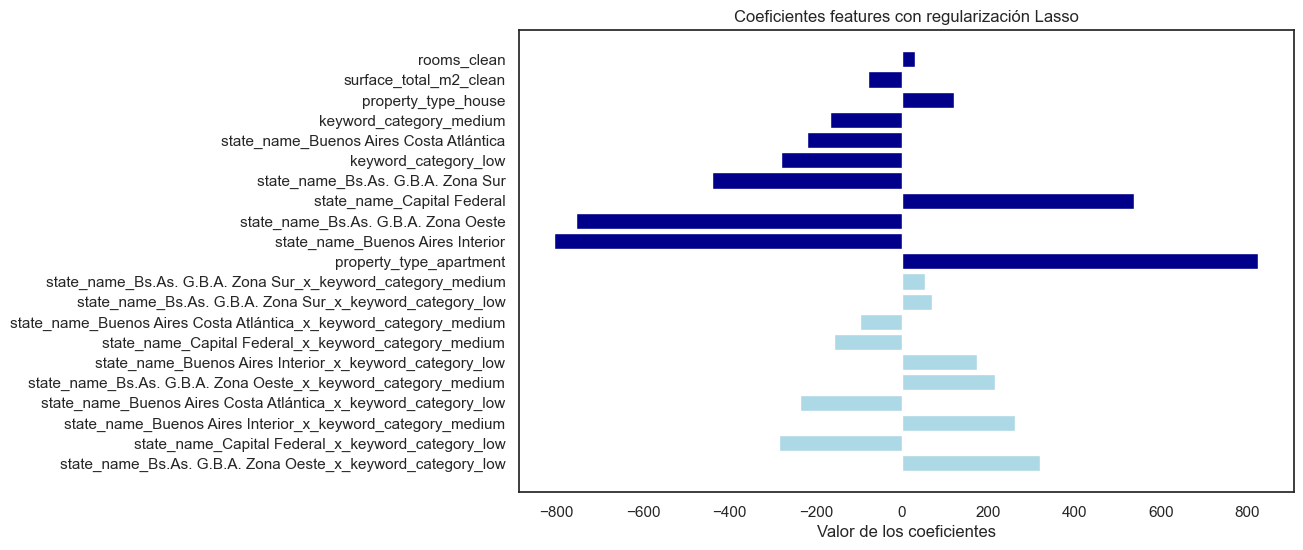

In [89]:
# Llamamos a los coeficientes de acuerdo al modelo
coeficientes = modelo_lasso_cv.coef_

# Ordenar en el gráfico las features de interacción y las de no-interacción
sorted_interaction_indices = (-abs(coeficientes[interaction_indices])).argsort()
sorted_interaction_feature_names = [interaction_features[i] for i in sorted_interaction_indices]
sorted_non_interaction_indices = (-abs(coeficientes[non_interaction_indices])).argsort()
sorted_non_interaction_feature_names = [non_interaction_features[i] for i in sorted_non_interaction_indices]
sorted_feature_names = sorted_interaction_feature_names + sorted_non_interaction_feature_names
sorted_coefficients = coeficientes[feature_names.get_indexer(sorted_feature_names)]

# Colores de acuerdo a si se trata de una feature de interacción o no-interacción
colors = ['lightblue' if 'x' in feature else 'darkblue' for feature in sorted_feature_names]

# Graficar
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_feature_names, sorted_coefficients, color=colors)
plt.xlabel('Valor de los coeficientes')
plt.title('Coeficientes features con regularización Lasso')

plt.show()

C:\Users\Tefi\AppData\Local\Temp\ipykernel_1472\1928021951.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(modelo_lasso_cv.coef_), y=X_multi.columns, palette=colors)


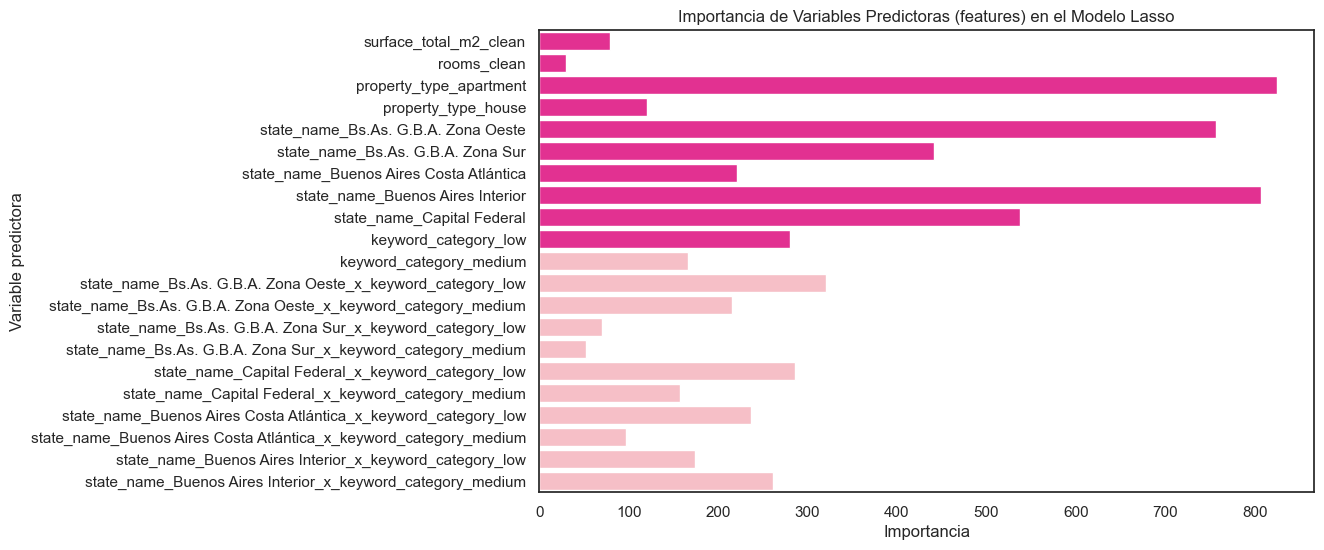

In [90]:
# Colores de acuerdo a si se trata de una feature de interacción o no-interacción
colors = ['deeppink' if 'x' in feature else 'lightpink' for feature in sorted_feature_names]

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=np.abs(modelo_lasso_cv.coef_), y=X_multi.columns, palette=colors)
plt.title('Importancia de Variables Predictoras (features) en el Modelo Lasso')
plt.xlabel('Importancia')
plt.ylabel('Variable predictora')

plt.show()

### 6) <u> Regresión Lineal Múltiple con Regularizacion RIDGE + Cross Valdation

In [91]:
best_score_ridge = -np.inf
best_fold_ridge = None

for folds in folds_range:
    ridge_cv_model = RidgeCV(alphas=alphas, cv=folds)
    scores_ridge = cross_val_score(ridge_cv_model, X_multi_train, y_multi_train, cv = folds)
    mean_score_ridge = scores_ridge.mean()
    if mean_score_ridge > best_score_ridge:
            best_score_ridge = mean_score_ridge
            best_fold_ridge = folds
    
print('Mejor número de folds para Ridge:', best_fold_ridge)
print('Mejor score promedio para Ridge:', best_score_ridge)

Mejor número de folds para Ridge: 4
Mejor score promedio para Ridge: 0.3682182515722233


In [92]:
ridge_cv_model = RidgeCV(alphas=alphas, cv=best_fold_ridge)
modelo_ridge_cv = ridge_cv_model.fit(X_multi_train, y_multi_train)

print("Los coeficientes del modelo Ridge son:")

coef_ridge = modelo_ridge_cv.coef_
for feature, coef_ridge in zip(X_multi.columns, coef_ridge):
    redondeo_coef_ridge = round(coef_ridge, 2)
    print(f'{feature}: {redondeo_coef_ridge}')

intercept_ridge = round(modelo_ridge_cv.intercept_, 2)
print("El intercepto del modelo Ridge es:", intercept_ridge)

# Best Alpha
best_alpha_ridge = round(ridge_cv_model.alpha_, 3)
print("Mejor alpha seleccionado por RidgeCV:", best_alpha_ridge)

# Score R2 datos de entrenamiento del modelo (train) (ya vistos en mejor_score_promedio)
train_score_ridge = round(modelo_ridge_cv.score(X_multi_train, y_multi_train), 4)
print("Score R2 del modelo en los datos de entrenamiento (Ridge):", train_score_ridge)

# Score R2 datos de prueba (test)
test_score_ridge = round(modelo_ridge_cv.score(X_multi_test, y_multi_test), 4)
print("Score R2 del modelo en los datos de prueba (Ridge):", test_score_ridge)

# Predicciones en los datos de test
y_test_pred_ridge = modelo_ridge_cv.predict(X_multi_test)

# Calculamos Errores para el Modelo Ridge
mse_ridge = mean_squared_error(y_multi_test, y_test_pred_ridge).round(3)
mae_ridge = mean_absolute_error(y_multi_test, y_test_pred_ridge).round(3)
rmse_ridge = np.sqrt(mean_squared_error(y_multi_test, y_test_pred_ridge)).round(3)
sse_ridge = np.sum(np.square(y_multi_test - y_test_pred_ridge)).round(3)

print("Error cuadrático medio del modelo (Ridge):", mse_ridge)
print("Error cuadrático absoluto del modelo (Ridge):", mae_ridge)
print("Raiz del Error cuadrático medio del modelo (Ridge):", rmse_ridge)
print("Suma de los errores cuadráticos (SSE) del modelo (Ridge):", sse_ridge)

Los coeficientes del modelo Ridge son:
surface_total_m2_clean: -78.66
rooms_clean: 29.69
property_type_apartment: 825.1
property_type_house: 120.27
state_name_Bs.As. G.B.A. Zona Oeste: -755.51
state_name_Bs.As. G.B.A. Zona Sur: -441.56
state_name_Buenos Aires Costa Atlántica: -220.43
state_name_Buenos Aires Interior: -802.46
state_name_Capital Federal: 537.15
keyword_category_low: -280.55
keyword_category_medium: -166.25
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_low: 319.12
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_medium: 214.63
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_low: 70.92
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_medium: 53.32
state_name_Capital Federal_x_keyword_category_low: -285.76
state_name_Capital Federal_x_keyword_category_medium: -157.18
state_name_Buenos Aires Costa Atlántica_x_keyword_category_low: -237.23
state_name_Buenos Aires Costa Atlántica_x_keyword_category_medium: -97.98
state_name_Buenos Aires Interior_x_keywo

El hecho de que los score de entrenamiento y prueba sean similares en la validación cruzada sugiere que el modelo generalizó bien frente a nueva información.

- Visualización de los resultados

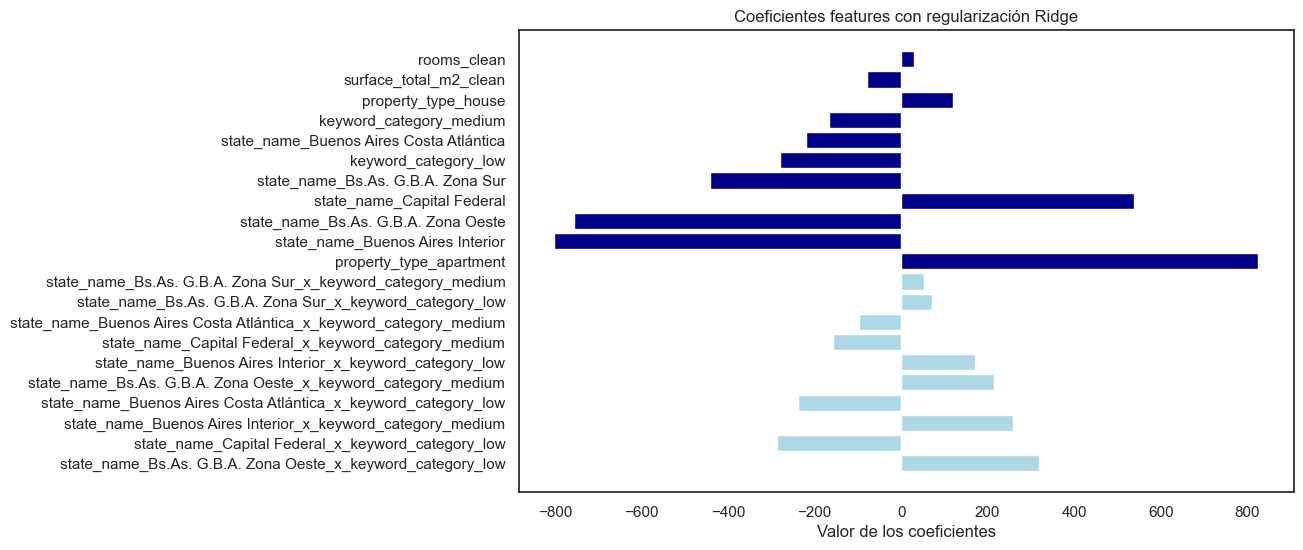

In [93]:
# Llamamos a los coeficientes de acuerdo al modelo
coeficientes = modelo_ridge_cv.coef_

# Ordenar en el gráfico las features de interacción y las de no-interacción
sorted_interaction_indices = (-abs(coeficientes[interaction_indices])).argsort()
sorted_interaction_feature_names = [interaction_features[i] for i in sorted_interaction_indices]
sorted_non_interaction_indices = (-abs(coeficientes[non_interaction_indices])).argsort()
sorted_non_interaction_feature_names = [non_interaction_features[i] for i in sorted_non_interaction_indices]
sorted_feature_names = sorted_interaction_feature_names + sorted_non_interaction_feature_names
sorted_coefficients = coeficientes[feature_names.get_indexer(sorted_feature_names)]

# Colores de acuerdo a si se trata de una feature de interacción o no-interacción
colors = ['lightblue' if 'x' in feature else 'darkblue' for feature in sorted_feature_names]

# Graficar
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_feature_names, sorted_coefficients, color=colors)
plt.xlabel('Valor de los coeficientes')
plt.title('Coeficientes features con regularización Ridge')

plt.show()

C:\Users\Tefi\AppData\Local\Temp\ipykernel_1472\2030214208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(modelo_ridge_cv.coef_), y=X_multi.columns, palette=colors)


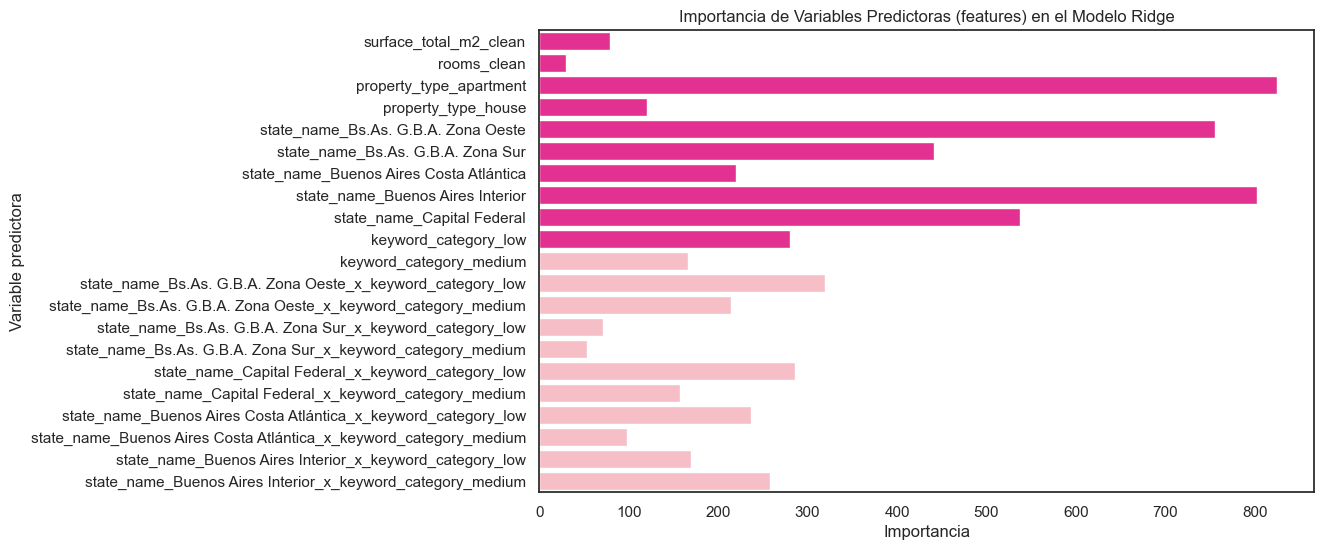

In [94]:
# Colores de acuerdo a si se trata de una feature de interacción o no-interacción
colors = ['deeppink' if 'x' in feature else 'lightpink' for feature in sorted_feature_names]

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=np.abs(modelo_ridge_cv.coef_), y=X_multi.columns, palette=colors)
plt.title('Importancia de Variables Predictoras (features) en el Modelo Ridge')
plt.xlabel('Importancia')
plt.ylabel('Variable predictora')

plt.show()

### 6) <u> Regresión Lineal Múltiple con Regularizacion ELASTIC NET + Cross Valdation

In [95]:
elastic_net_cv_model = ElasticNetCV(alphas=alphas, l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], cv=best_fold_ridge)

# Fit datos training
modelo_elastic_net_cv = elastic_net_cv_model.fit(X_multi_train, y_multi_train)

#Coeficientes
print("Los coeficientes del modelo Elastic Net son:")
coef_elastic_net = modelo_elastic_net_cv.coef_
for feature, coef in zip(X_multi.columns, coef_elastic_net):
    redondeo_coef_elastic_net = round(coef, 2)
    print(f'{feature}: {redondeo_coef_elastic_net}')

intercept_elastic_net = round(modelo_elastic_net_cv.intercept_, 2)
print("El intercepto del modelo Elastic Net es:", intercept_elastic_net)

# Best alpha
best_alpha_elastic_net = round(elastic_net_cv_model.alpha_, 2)
best_l1_ratio_elastic_net = round(elastic_net_cv_model.l1_ratio_, 2)
print("Mejor alpha seleccionado por Elastic Net CV:", best_alpha_elastic_net)
print("Mejor l1_ratio seleccionado por Elastic Net CV:", best_l1_ratio_elastic_net)

# R2 Train
train_score_elastic_net = round(modelo_elastic_net_cv.score(X_multi_train, y_multi_train), 4)
print("Score R2 del modelo en los datos de entrenamiento (Elastic Net):", train_score_elastic_net)

# R2 Test (ajuste modelo a datos nuevos)
test_score_elastic_net = round(modelo_elastic_net_cv.score(X_multi_test, y_multi_test), 4)
print("Score R2 del modelo en los datos de prueba (Elastic Net):", test_score_elastic_net)
y_test_pred_elastic_net = modelo_elastic_net_cv.predict(X_multi_test)

# Calculamos Errores para el Modelo Elastic Net
mse_elastic_net = mean_squared_error(y_multi_test, y_test_pred_elastic_net).round(3)
mae_elastic_net = mean_absolute_error(y_multi_test,y_test_pred_elastic_net).round(3)
rmse_elastic_net = np.sqrt(mean_squared_error(y_multi_test, y_test_pred_elastic_net)).round(3)
sse_elastic_net = np.sum(np.square(y_multi_test - y_test_pred_elastic_net)).round(3)

print("Error cuadrático medio del modelo (Elastic Net):", mse_elastic_net)
print("Error cuadrático absoluto del modelo (Elastic Net):", mae_elastic_net)
print("Raiz del Error cuadrático medio del modelo (Elastic Net):", rmse_elastic_net)
print("Suma de los errores cuadráticos (SSE) del modelo (Elastic Net):", sse_elastic_net)


Los coeficientes del modelo Elastic Net son:
surface_total_m2_clean: -78.65
rooms_clean: 29.68
property_type_apartment: 824.93
property_type_house: 120.1
state_name_Bs.As. G.B.A. Zona Oeste: -752.9
state_name_Bs.As. G.B.A. Zona Sur: -440.58
state_name_Buenos Aires Costa Atlántica: -220.11
state_name_Buenos Aires Interior: -789.73
state_name_Capital Federal: 537.44
keyword_category_low: -280.12
keyword_category_medium: -165.79
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_low: 316.42
state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_medium: 211.87
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_low: 69.9
state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_medium: 52.28
state_name_Capital Federal_x_keyword_category_low: -286.05
state_name_Capital Federal_x_keyword_category_medium: -157.5
state_name_Buenos Aires Costa Atlántica_x_keyword_category_low: -237.53
state_name_Buenos Aires Costa Atlántica_x_keyword_category_medium: -98.3
state_name_Buenos Aires Interior_x_key

- Visualización de los resultados

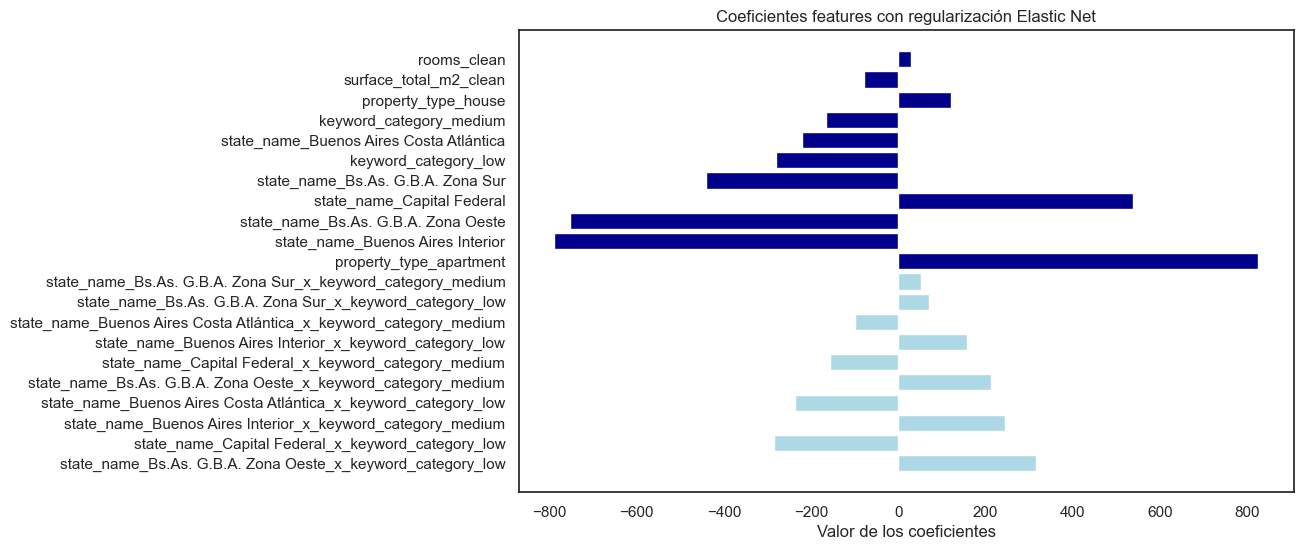

In [96]:
# Llamamos a los coeficientes de acuerdo al modelo
coeficientes = modelo_elastic_net_cv.coef_

# Ordenar en el gráfico las features de interacción y las de no-interacción
sorted_interaction_indices = (-abs(coeficientes[interaction_indices])).argsort()
sorted_interaction_feature_names = [interaction_features[i] for i in sorted_interaction_indices]
sorted_non_interaction_indices = (-abs(coeficientes[non_interaction_indices])).argsort()
sorted_non_interaction_feature_names = [non_interaction_features[i] for i in sorted_non_interaction_indices]
sorted_feature_names = sorted_interaction_feature_names + sorted_non_interaction_feature_names
sorted_coefficients = coeficientes[feature_names.get_indexer(sorted_feature_names)]

# Colores de acuerdo a si se trata de una feature de interacción o no-interacción
colors = ['lightblue' if 'x' in feature else 'darkblue' for feature in sorted_feature_names]

# Graficar
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_feature_names, sorted_coefficients, color=colors)
plt.xlabel('Valor de los coeficientes')
plt.title('Coeficientes features con regularización Elastic Net')

plt.show()

C:\Users\Tefi\AppData\Local\Temp\ipykernel_1472\23367976.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(modelo_elastic_net_cv.coef_), y=X_multi.columns, palette=colors)


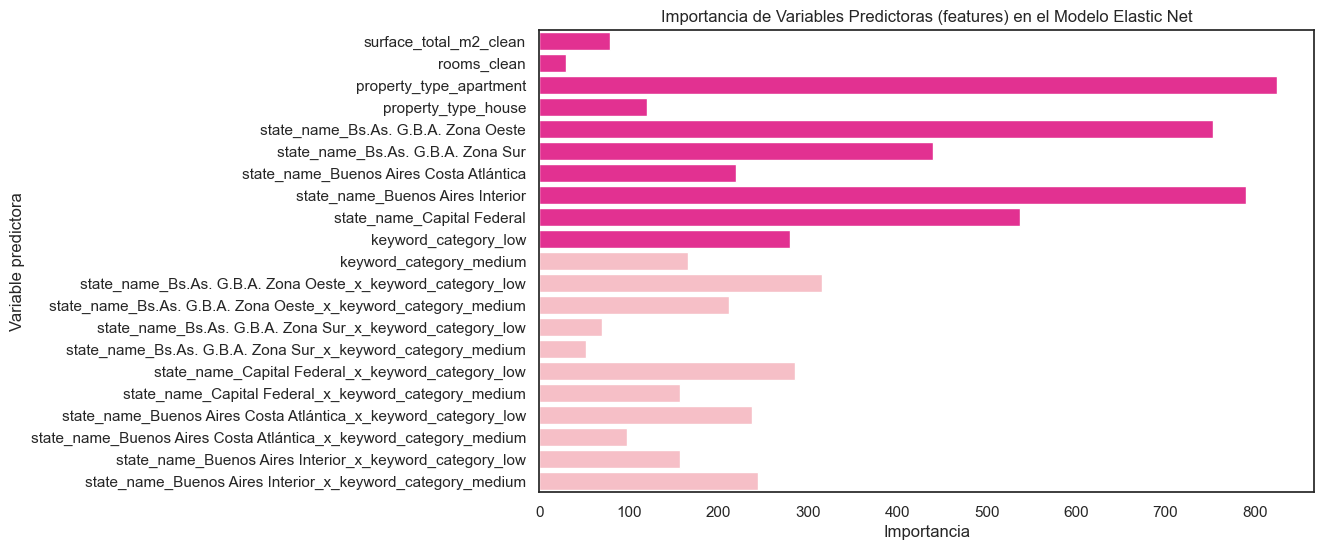

In [97]:
# Colores de acuerdo a si se trata de una feature de interacción o no-interacción
colors = ['deeppink' if 'x' in feature else 'lightpink' for feature in sorted_feature_names]

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=np.abs(modelo_elastic_net_cv.coef_), y=X_multi.columns, palette=colors)
plt.title('Importancia de Variables Predictoras (features) en el Modelo Elastic Net')
plt.xlabel('Importancia')
plt.ylabel('Variable predictora')

plt.show()

Creamos una tabla comparativa de los diferentes Errores en cada Modelo aplicado y analizado.

- Gráficos interactivos

In [98]:
coef_df_elastic_net = pd.DataFrame({
    'Característica': X_multi.columns,
    'Coeficiente': modelo_elastic_net_cv.coef_,
    'Importancia': np.abs(modelo_elastic_net_cv.coef_)
})

# Coeficientes
fig_coef_elastic_net = px.bar(coef_df_elastic_net, x='Característica', y='Coeficiente', text='Coeficiente',
                              title='Coeficientes del Modelo Elastic Net',
                              labels={'Coeficiente': 'Coeficiente Elastic Net'},
                              color='Coeficiente', color_continuous_scale='RdBu_r')

fig_coef_elastic_net.update_layout(xaxis_tickangle=-20, showlegend=False)
fig_coef_elastic_net.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_coef_elastic_net.update_xaxes(tickfont=dict(size=8), title_standoff=0.5)

# Importancia de Características
fig_importance_elastic_net = px.bar(coef_df_elastic_net, x='Característica', y='Importancia',
                                    title='Importancia de Características en el Modelo Elastic Net',
                                    labels={'Importancia': 'Importancia'},
                                    color='Importancia', color_continuous_scale='RdBu_r')

fig_importance_elastic_net.update_layout(xaxis_tickangle=-20, showlegend=False)
fig_importance_elastic_net.update_xaxes(tickfont=dict(size=8), title_standoff=0.5)

# Mostrar los gráficos interactivos para Elastic Net
fig_coef_elastic_net.show()
fig_importance_elastic_net.show()

### 7) <u> Comparación de los resultados obtenidos a través de los modelos de Regresión Lineal Múltiple y conclusiones

In [99]:
linear_regression = {
    'valores': ['y=0', 'surface_total_m2_clean', 'rooms_clean', 'property_type_apartment', 'property_type_house',
                'state_name_Bs.As. G.B.A. Zona Oeste', 'state_name_Bs.As. G.B.A. Zona Sur', 'state_name_Capital Federal',
                'state_name_Buenos Aires Costa Atlántica', 'state_name_Buenos Aires Interior', 'keyword_category_low',
                'keyword_category_medium', 'state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_low',
                'state_name_Bs.As. G.B.A. Zona Oeste_x_keyword_category_medium', 'state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_low',
                'state_name_Bs.As. G.B.A. Zona Sur_x_keyword_category_medium', 'state_name_Capital Federal_x_keyword_category_low',
                'state_name_Capital Federal_x_keyword_category_medium', 'state_name_Buenos Aires Costa Atlántica_x_keyword_category_low',
                'state_name_Buenos Aires Costa Atlántica_x_keyword_category_medium', 'state_name_Buenos Aires Interior_x_keyword_category_low',
                'state_name_Buenos Aires Interior_x_keyword_category_medium', 'Error cuadrático absoluto', 'Error cuadrático medio', 'Raiz del Error cuadrático medio', 'Suma de los errores cuadráticos', 'R2'],
    'linear_regression': [1688.1506078071861, -78.68, 29.69, 825.36, 120.55, -759.74, -443.17, 536.65, -220.98, -824.38, -281.28, -167.01,
                          323.5, 219.1, 72.57, 55.03, -285.25, -156.63, -236.7, -97.42, 192.03, 281.27, 562.3, 627986.97, 792.46, 11009239518.97, 0.3774]
}

lasso = {
    'lasso': [1687.7, -78.64, 29.68, 825.2, 120.31, -756.55, -441.02, 537.07, -220.8, -806.86, -280.58, -166.28, 320.13, 215.56, 70.28, 52.62, -285.72, -157.12, -236.88, -97.52, 173.98, 261.87, 562.3, 627995.06, 792.46, 11009340377.47, 0.3774]
}

ridge = {
    'ridge': [1687.71, -78.66, 29.69, 825.1, 120.27, -755.51, -441.56, 537.15, -220.43, -802.46, -280.55, -166.25,
              319.12, 214.63, 70.92, 53.32, -285.76, -157.18, -237.23, -97.98, 169.83, 257.86, 562.3, 627992.72, 792.46, 11009381311.53, 0.3774]
}

elastic_net = {
    'elastic_net': [1687.45, -78.65, 29.68, 824.93, 120.1, -752.9, -440.58, 537.44, -220.11, -789.73, -280.12, -165.79,
                    316.42, 211.87, 69.9, 52.28, -286.05, -157.5, -237.53, -98.3, 156.97, 244.32, 562.3, 628000.56, 792.47, 11009477761.46, 0.3774]
}


# Crear DataFrames con los datos
df_linear_regression = pd.DataFrame(linear_regression)
df_ridge = pd.DataFrame(ridge)
df_lasso = pd.DataFrame(lasso)
df_elastic_net = pd.DataFrame(elastic_net)

# Calcular las diferencias para Ridge, Lasso y Elastic Net
df_ridge_dif = df_ridge.subtract(df_linear_regression['linear_regression'], axis=0)
df_lasso_dif = df_lasso.subtract(df_linear_regression['linear_regression'], axis=0)
df_elastic_net_dif = df_elastic_net.subtract(df_linear_regression['linear_regression'], axis=0)

df_conclusion = pd.DataFrame({
    'valores': df_linear_regression['valores'],
    'RLM': df_linear_regression['linear_regression'].apply(lambda x: format(x, '.2f')),
    'lasso': df_lasso_dif['lasso'].round(2),
    'ridge': df_ridge_dif['ridge'].round(2),
    'elastic_net': df_elastic_net_dif['elastic_net'].round(2),
})

df_conclusion

,valores,RLM,lasso,ridge,elastic_net
0,y=0,1688.15,-0.45,-0.44,-0.70
1,surface_total_m2_clean,-78.68,0.04,0.02,0.03
2,rooms_clean,29.69,-0.01,0.00,-0.01
3,property_type_apartment,825.36,-0.16,-0.26,-0.43
4,property_type_house,120.55,-0.24,-0.28,-0.45
5,state_name_Bs.As. G.B.A. Zona Oeste,-759.74,3.19,4.23,6.84
6,state_name_Bs.As. G.B.A. Zona Sur,-443.17,2.15,1.61,2.59
7,state_name_Capital Federal,536.65,0.42,0.50,0.79
8,state_name_Buenos Aires Costa Atlántica,-220.98,0.18,0.55,0.87
9,state_name_Buenos Aires Interior,-824.38,17.52,21.92,34.65


In [100]:
# Creamos una tabla comparativa de los Errores de cada modelo
data_errores = {
    'Modelo': ['RLM', 'Lasso', 'Ridge', 'Elastic Net'],
    'MSE en test': [mse_rlm , mse_lasso, mse_ridge, mse_elastic_net],
    'RMSE en test': [rmse_rlm , rmse_lasso, rmse_ridge, rmse_elastic_net],
    'MAE en test': [mae_rlm, mae_lasso, mae_ridge, mae_elastic_net],
    'SSE en test': [sse_rlm, sse_lasso, sse_ridge, sse_elastic_net]
}
df_errores = pd.DataFrame(data_errores)

# Imprimir la tabla con formato de tabla
print(df_errores.to_string(index=False))

     Modelo  MSE en test  RMSE en test  MAE en test  SSE en test
        RLM   627986.967       792.456      562.295 1.100924e+10
      Lasso   627992.746       792.460      562.296 1.100934e+10
      Ridge   627995.055       792.461      562.295 1.100938e+10
Elastic Net   628000.557       792.465      562.295 1.100948e+10


In [101]:
#Expresamos los mismos valores como diferencias del modelo estándar y generamos otra tabla

diff_mse_lasso = mse_lasso - mse_rlm
diff_rmse_lasso = rmse_lasso - rmse_rlm
diff_mae_lasso = mae_lasso - mae_rlm
diff_sse_lasso = sse_lasso - sse_rlm

diff_mse_ridge = mse_ridge - mse_rlm
diff_rmse_ridge = rmse_ridge - rmse_rlm
diff_mae_ridge = mae_ridge - mae_rlm
diff_sse_ridge = sse_ridge - sse_rlm

diff_mse_elastic_net = mse_elastic_net - mse_rlm
diff_rmse_elastic_net = rmse_elastic_net - rmse_rlm
diff_mae_elastic_net = mae_elastic_net - mae_rlm
diff_sse_elastic_net = sse_elastic_net - sse_rlm

data_errores = {
    'Modelo': ['RLM', 'Lasso', 'Ridge', 'Elastic Net'],
    'Δ MSE': [mse_rlm, diff_mse_lasso, diff_mse_ridge, diff_mse_elastic_net],
    'Δ RMSE': [rmse_rlm, diff_rmse_lasso, diff_rmse_ridge, diff_rmse_elastic_net],
    'Δ MAE': [mae_rlm, diff_mae_lasso, diff_mae_ridge, diff_mae_elastic_net],
    'Δ SSE': [sse_rlm, diff_sse_lasso, diff_sse_ridge, diff_sse_elastic_net]
}

df_errores = pd.DataFrame(data_errores)

# Print the table with a tabular format
print(df_errores.to_string(index=False))

     Modelo      Δ MSE  Δ RMSE   Δ MAE        Δ SSE
        RLM 627986.967 792.456 562.295 1.100924e+10
      Lasso      5.779   0.004   0.001 1.013060e+05
      Ridge      8.088   0.005   0.000 1.417926e+05
Elastic Net     13.590   0.009   0.000 2.382448e+05


In [102]:
#Tomar los datos del DataFrame df_conclusion
df = df_conclusion.copy()
df.drop(index=25, inplace=True)

# Crear subgráficos
fig = make_subplots(rows=1, cols=3, subplot_titles=['Lasso', 'Ridge', 'Elastic Net'])

# Lista de colores para cada regresión
colors = ['turquoise', 'darkviolet', 'fuchsia']

# Agregar barras para diferencias de coeficientes con respecto a RLM estándar
for i, col in enumerate(df.columns[2:]):
    # En el primer subplot, agregar referencias del eje y
    if i == 0:
        fig.add_trace(go.Bar(x=df[col], y=df['valores'], orientation='h', marker=dict(color=colors[i]),
                             name=f'Diferencia con RLM Estándar - {col}'), row=1, col=i + 1)
    else:
        fig.add_trace(go.Bar(x=df[col], orientation='h', marker=dict(color=colors[i]),
                             name=f'Diferencia con RLM Estándar - {col}'), row=1, col=i + 1)

# Configurar diseño del gráfico
fig.update_layout(height=800, width=1200, title_text="Diferencias de Coeficientes Regularizados con respecto a RLM Estándar",
                  showlegend=False, yaxis=dict(categoryorder='total ascending'))

# Establecer el rango para el eje X en los subgráficos izquierdo y derecho
fig.update_xaxes(range=[-40, 40], row=1, col=1)
fig.update_xaxes(range=[-40, 40], row=1, col=2)
fig.update_xaxes(range=[-40, 40], row=1, col=3)

# Mostrar el gráfico
fig.show()

- Tanto en Ridge como en Lasso encontramos que los hiperparámetros alpha/lambda fueron bajos. Esto quiere decir que el impacto de la regularización en la magnitud de los coeficientes (penalización) es mínimo, y los modelos tienden a comportarse más como la regresión lineal estándar (RLM o lineal_regression en este informe) - en otras palabras, la regularización parecería no ofrecer beneficios significativos. Sin embargo, cada uno de estos modelos tiene sus propias propiedades distintivas incluso con alpha bajo, como la capacidad de Ridge para manejar colinealidad entre las variables y la selección de features que podemos realizar con Lasso. Lo que sorprende es la incapacidad de los tres modelos de regularización de disminuir los errores de la RLM estándar.

- En la tabla comparativa se ven las mínimas diferencias entre los coeficientes en cada modelo. En orden, el efecto de regularización introducida por cada uno (evaluado a través del cambio en los coeficientes) es: Ridge < Lasso < Elastic Net.

- Las diferencias son algo mayores en Elastic Net porque este pondera la aplicación de l1(Lasso) y l2 (Ridge) óptimos y toma características de ambas. Sin embargo, son ciertamente diferencias muy pequeñas si las comparamos con los coeficientes y valores originales. Y, finalmente, esto es lo que se refleja en un R2 moderado, constante entre todos los modelos (incluyendo R2 ajustado), pero que aplica correctamente a los datos de prueba.

- Las features relativamente más importantes (o variables predictoras) en nuestro modelo fueron: "property_type_apartment" (+), "state_name_Capital_Federal" (+), "state_name_Bs.As. G.B.A. Zona Oeste" (-) y "state_name_Buenos Aires Interior" (-) (ver gráficos en cada modelo para detalles)

- El valor de R2 indica la proporción de la variabilidad en la variable dependiente que es explicada por el modelo. En general, los valores de R2 son bajos en todos los modelos, lo que sugiere que hay aspectos no capturados por las features incluidas en los mismos. Este valor casi no se modifica al introducir la regularización para evitar el sobreajuste, lo que pareciera indicar que no era este un problema en el modelo original.

### 8) Conclusiones generales y resumen

- El modelo de regresión lineal simple con "surface_total_m2_clean" como feature muestra un R2 de 0.105, indicando que este modelo explica aproximadamente el 10.5% de la variabilidad en la variable target. La regresión lineal múltiple muestra un rendimiento relativamente mejor con un R2 de 0.3774 en todas sus variantes.

- Las regularizaciones de Lasso, Ridge y Elastic Net parecerían no ofrecer beneficios significativos. Cada uno de estos modelos tiene sus propias propiedades distintivas incluso con α bajo, como la capacidad de Ridge para manejar multicolinealidad y la capacidad de Lasso para realizar selección de características, pero esto debería llevar a una reducción de los errores (principalmente la función de pérdida, SSE). 

- Siguiendo con el punto anterior, el sobreajuste no parecería ser un problema en nuestro modelo de RLM, a pesar de haber incluido features con coeficientes relativamente bajos (como la superficie total y el número de habitaciones) e interacciones que no eran estadísticamente significativas según el análisis de Stats Models. Tomando todos estos puntos en consideración, decidimos que el modelo de RLM estándar como primera elección.

- Las features relativamente más importantes (o variables predictoras) en nuestro modelo de RLM fueron: "property_type_apartment" (+), "state_name_Bs.As. G.B.A. Zona Oeste" (-), "state_name_Buenos Aires Interior" (-) y, de forma distante, "state_name_Capital_Federal" (+).

- En general, los valores de R2 son bajos en todos los modelos, lo que sugiere que hay aspectos no capturados por las características incluidas en los mismos. Como pasos a futuro, se podría explorar la inclusión de más características relevantes, así como ajustes en los hiperparámetros de regularización (alpha / lambda), o probar los modelos en nuevos conjuntos de datos de prueba para optimizarlos.

## b) <u> Bonus track : Automatización de la generación de modelos de regresión

#### - Manejo de data ingresada por el usuario

In [103]:
# Cargamos el archivo csv y lo convertimos a df
def data(csv_archivo):
    data_f = pd.read_csv(csv_archivo, sep = ",", low_memory=False)
    return data_f

# Considerando los posibles tipos de features procesamos para que sirvan para nuestros modelos
def preprocess_data(X, y, features_cat, features_cuant):
    # División train test dentro del preprocesamiento
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

    preprocessor = ColumnTransformer(
        transformers=[
             # Para las características cuantitativas, aplicamos un escalador estándar
            ('cuant', StandardScaler(), features_cuant),
        # Para las características categóricas, aplicamos un codificador OneHot
        # con la opción handle_unknown='ignore' para manejar categorías desconocidas(por la posible diferencia en los datos de test y train)
            ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat)]) 

    # Transforma el conjunto de entrenamiento
    X_train = preprocessor.fit_transform(X_train)

    # Transforma el conjunto de prueba
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test

# Evaluamos el modelo y devuelve las metricas de la  misma
def evaluacion_modelo(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2, y_pred


### Grafico para resultados

In [104]:
#Gráfico
def grafico(y_test,y_pred):
    sample_size = 2000
    y_pred_sample = y_pred[:sample_size]
    y_test_sample = y_test[:sample_size]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred_sample, y=y_test_sample)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
    plt.xlim(0, 4000)
    plt.title('Predicciones vs. Valores Reales (2000 samples)')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.show()


#### - Funciones para cada modelo

In [105]:
# Funciones con las variables y pasos mas basico de cada modelo

# Modelo linear
def linear_model(X_train, X_test, y_train, y_test): 
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    mse, r2, y_pred = evaluacion_modelo(model, X_test, y_test)
    resultados = print(f"MSE: {mse}, R2: {r2}")
    return resultados, y_pred

# Modelo Linear con Ridge
def ridge_model(X_train, X_test, y_train, y_test):
    alpha = input("Ingrese el valor de alpha para el modelo Ridge (o 'auto' para búsqueda automática): ")
    
    if alpha == 'auto':
        alpha_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
        model = GridSearchCV(Ridge(), alpha_grid, cv=5, scoring='neg_mean_squared_error')
        model.fit(X_train, y_train)
        alpha = model.best_params_['alpha']
        print(f"Mejor valor de alpha encontrado: {alpha}")
    else:
        alpha = float(alpha)
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

    mse, r2, y_pred = evaluacion_modelo(model, X_test, y_test)
    resultados = print(f"MSE: {mse}, R2: {r2}")

    return resultados, y_pred

# Modelo Linear con Lasso
def lasso_model(X_train, X_test, y_train, y_test):
    alpha = input("Ingrese el valor de alpha para el modelo Lasso (o 'auto' para búsqueda automática): ")
    
    if alpha == 'auto':
        alpha_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
        
        # Iteramos sobre los valores de alpha_grid para encontrar el que devuelva el mejor scoring
        model = GridSearchCV(Lasso(), alpha_grid, cv=5, scoring='neg_mean_squared_error')
        model.fit(X_train, y_train)
        
        # Devuelve el valor del hiperparametro que mejor score recibe
        alpha = model.best_params_['alpha']
        print(f"Mejor valor de alpha encontrado: {alpha}")
    else:
        alpha = float(alpha)
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)

    mse, r2, y_pred = evaluacion_modelo(model, X_test, y_test)
    resultados = print(f"MSE: {mse}, R2: {r2}")
 
    return resultados, y_pred

#### - Función principal (Programa)

Donde el usuario ingresa y participa de la eleccion y ejecucion de los Modelos

In [106]:
# En esta funcion se ejecutan todas las previas, el usuario ingresa archivo, tipo de modelo, los features y target que desea aplicar
def main():
    archivo = input("Ingrese el nombre del archivo CSV: ")
    data_f = data(archivo) #df_RLM
    print(data_f.info())

    model_type = input("Ingrese el tipo de modelo (linear, ridge, lasso): ")
    if model_type not in ['linear', 'ridge', 'lasso']:
        print("Modelo no disponible")
        return
    else:
        print(model_type)
        
    features = input("Ingrese las features, separadas por comas: ").split(',')
    print(f"Features seleccionadas: {features}")
    target = input("Ingrese el target: ")
    print(f"Target seleccionado: {target}")

    X = data_f[features]
    y = data_f[target]

    #Separamos las features segun su tipo para poder manejar segun corresponda
    features_cat = X.select_dtypes(include=['object']).columns.tolist()
    features_cuant = X.select_dtypes(exclude=['object']).columns.tolist()

    # Procesamos las features segun su tipo
    X_train, X_test, y_train, y_test = preprocess_data(X, y, features_cat, features_cuant)


    # Segun el modelo elegido por el usuario se va a devolver el mse y r2 que corresponda a cada modelo

    if model_type == 'linear':
        resultados, y_pred = linear_model(X_train, X_test, y_train, y_test) 
    elif model_type == 'ridge':
        resultados, y_pred = ridge_model(X_train, X_test, y_train, y_test)
    elif model_type == 'lasso':
        resultados, y_pred = lasso_model(X_train, X_test, y_train, y_test)

    resultados
    grafico(y_pred, y_test)


In [ ]:
main()

###### Nota: este programa nos permitió probar códigos en datos de train que posiblemente hubieran sido poco factibles generando dummies de forma manual, y que creemos sobreajustan al exhibir R2 altos que no repitirían en datos desconocidos.